# West Nile Virus Prediction
This notebook focuses on West Nile Virus (WNV) feature engineering for building prediction models.

## Objective
The objective is to build a model that can accurately predict outbreaks of West Nile Virus in mosquitos using weather, location, testing, and spraying data for the City of Chicago.

## Data Overview (from Kaggle)
Every year from late-May to early-October, public health workers in Chicago setup mosquito traps scattered across the city. Every week from Monday through Wednesday, these traps collect mosquitos, and the mosquitos are tested for the presence of West Nile virus before the end of the week. The test results include the number of mosquitos, the mosquitos species, and whether or not West Nile virus is present in the cohort.

## Datasets Provided
1. train.csv - training set of the main dataset, consisting of data from 2007, 2009, 2011, and 2013
2. test.csv - test set of the main dataset, consisting of data from 2008, 2010, 2012, and 2014. For each record in the test set, probability of presence of WNV is to be predicted
3. spray.csv - GIS data of spraying efforts in 2011 and 2013
4. weather.csv - weather data from 2007 to 2014

### Weather
weather.csv has weather data from NOAA for the period 2007 to 2014, with a total of 2944 entries. The data includes information regarding temperature, dewpoint, sunrise / sunset times, weather conditions, Water / Snowfall, precipitation, pressure at station, sealevel and wind conditions. The data is provided from two stations:

Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level

Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

Weather has a significant influence on the presence of mosquitos. It is believed that hot and dry conditions are more favorable for WNV than cold and wet. However, mosquitos thrive when there is presence of water as their eggs are laid on the water surface. Therefore precipitation influences formation of puddles (considering surface conditions as constant), and therefore influx of mosquitos. Mosquitoes cannot live or function properly when the air temperature is below 10 degrees Celsius (50 degrees Fahrenheit). They are mostly active at 60–80 degrees Fahrenheit.[[ref]](https://www.bbc.co.uk/sounds/play/p01hnv98)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
weather = pd.read_csv('weather.csv')

In [3]:
weather.head()

Station        Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1  2007-05-01    83    50   67     14        51      56    0    2   
1        2  2007-05-01    84    52   68      M        51      57    0    3   
2        1  2007-05-02    59    42   51     -3        42      47   14    0   
3        2  2007-05-02    60    43   52      M        42      47   13    0   
4        1  2007-05-03    66    46   56      2        40      48    9    0   

   ... CodeSum Depth Water1 SnowFall PrecipTotal StnPressure SeaLevel  \
0  ...             0      M      0.0        0.00       29.10    29.82   
1  ...             M      M        M        0.00       29.18    29.82   
2  ...      BR     0      M      0.0        0.00       29.38    30.09   
3  ...   BR HZ     M      M        M        0.00       29.44    30.08   
4  ...             0      M      0.0        0.00       29.39    30.12   

  ResultSpeed ResultDir  AvgSpeed  
0         1.7        27       9.2  
1         2.7        25       9.6  
2        13.0         4      13.4  
3        13.3         2      13.4  
4        11.7         7      11.9  

[5 rows x 22 columns]

In [4]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

##### Temperature
Based on the NOAA Quality Controlled Local Climatological Data file, missing information is encoded as 'M', trace amounts of precipitation as 'T', and '-' for missing information in sunrise and sunset. Many of the numeric variables show datatype as object rather than integer or float.

Starting with temperature, Tmax and Tmin have no missing values. While Tavg and Depart have missing values. From the records it can be observed that Tavg is calculated from Tmax and Tmin, and rounded off to the nearest integer value. In total 11 of 2944 records have missing Tavg. These values can be imputed from Tmax, and Tmin.

'Depart' is the departure of Tavg from normal. From the data it can be observed that the "normal" for the data records is 54F. Therefore missing values for Depart can be imputed from Tavg.

In [5]:
weather[['Tmax', 'Tmin', 'Tavg', 'Depart']].describe()

Tmax         Tmin
count  2944.000000  2944.000000
mean     76.166101    57.810462
std      11.461970    10.381939
min      41.000000    29.000000
25%      69.000000    50.000000
50%      78.000000    59.000000
75%      85.000000    66.000000
max     104.000000    83.000000

In [6]:
weather[['Tmax', 'Tmin', 'Tavg', 'Depart']].isna().any()

Tmax      False
Tmin      False
Tavg      False
Depart    False
dtype: bool

In [7]:
weather['Tavg'] = pd.to_numeric(weather['Tavg'], errors='coerce')
missing_locs = weather['Tavg'].isna()

print(f'Number of missing data for Tavg: {missing_locs.sum()}')


Number of missing data for Tavg: 11


In [8]:
weather['Tavg'].fillna(weather[['Tmin', 'Tmax']].mean(axis=1).round(), inplace=True)
weather['Tavg'] = weather['Tavg'].astype(int)


In [9]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   int64  
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [10]:
weather['Depart'] = pd.to_numeric(weather['Depart'], errors='coerce')
weather['Depart'].fillna(weather['Tavg'] - 54, inplace=True)
weather['Depart'] = weather['Depart'].astype(int)


In [11]:
print(weather[['Tmax', 'Tmin', 'Tavg', 'Depart']].isna().any())
weather[['Tmax', 'Tmin', 'Tavg', 'Depart']].describe()

Tmax      False
Tmin      False
Tavg      False
Depart    False
dtype: bool


Tmax         Tmin         Tavg       Depart
count  2944.000000  2944.000000  2944.000000  2944.000000
mean     76.166101    57.810462    67.239470     7.913383
std      11.461970    10.381939    10.539316    10.694073
min      41.000000    29.000000    36.000000   -18.000000
25%      69.000000    50.000000    60.000000     0.000000
50%      78.000000    59.000000    69.000000     7.000000
75%      85.000000    66.000000    75.000000    16.000000
max     104.000000    83.000000    94.000000    40.000000

DewPoint and WetBulb temperatures are indicative of the humidity. In a saturated air parcel (with relative humidity 100%) the wet bulb, dry bulb and dew point temperatures are all the same. In a drier parcel of air, the dry bulb is just the air temperature which will be the warmest of the three variables. The dew point will be the lowest number, and the wet bulb will fall between those two.

The dataset has no missing values for DewPoint, but the WetBulb temperature has 4 missing values, 3 for station 1 and 1 for station 2, all on different days. The missing values correspond to 0.13% of the data. Considering the location of weather stations in Chicago, it is safe to assume that the WetBulb temperature would be similar in magnitude at both locations. Therefore, for the present scenario missing values are imputed from corresponding stations that have values on the missing days.

In [12]:
weather[['DewPoint', 'WetBulb']].head()

DewPoint WetBulb
0        51      56
1        51      57
2        42      47
3        42      47
4        40      48

In [13]:
weather['WetBulb'] = pd.to_numeric(weather['WetBulb'], errors='coerce')
missing_wetbulb = weather[weather['WetBulb'].isna()]

print(f'Number of missing data for WetBulb: {len(missing_wetbulb)}')

Number of missing data for WetBulb: 4


In [15]:
missing_wetbulb[['Date', 'Station', 'DewPoint', 'WetBulb']]

Date  Station  DewPoint  WetBulb
848   2009-06-26        1        60      NaN
2410  2013-08-10        1        57      NaN
2412  2013-08-11        1        61      NaN
2415  2013-08-12        2        63      NaN

In [16]:
# convert date to datetime
weather.Date = pd.to_datetime(weather.Date)

In [17]:
def fill_missing_data(df, field):
    # Convert the field to numeric, making non-numeric values NaN
    df[field] = pd.to_numeric(df[field], errors='coerce')

    # Find the rows where data is missing
    missing_data_rows = df[df[field].isna()]

    # Print the number of missing data
    print(f'Number of missing data for {field}: {len(missing_data_rows)}')

    # For each row with missing data
    for _, row in missing_data_rows.iterrows():
        # Find the corresponding data from the other station
        corresponding_data = df[(df['Date'] == row['Date']) & (df['Station'] != row['Station'])][field]

        # If there is corresponding data, use it to fill in the missing data
        if not corresponding_data.empty:
            df.loc[row.name, field] = corresponding_data.values[0]

    # Convert the field back to int
    df[field] = df[field].astype(int)

    return df[field]


In [18]:
for field in ['WetBulb']:
    weather['WetBulb'] = fill_missing_data(weather, 'WetBulb')
print(weather[['DewPoint', 'WetBulb']].describe())

Number of missing data for WetBulb: 4
          DewPoint      WetBulb
count  2944.000000  2944.000000
mean     53.457880    59.319293
std      10.675181     9.283540
min      22.000000    32.000000
25%      46.000000    53.000000
50%      54.000000    61.000000
75%      62.000000    67.000000
max      75.000000    78.000000


##### Heat and Cool
Heat and Cool corresponds to the number of heating and cooling degree days relative to 65F (NOAA Documentation). The number of heating and cooling days are missing for 11 records for station 2, on the same days. Considering the region of the data is small and that the weather stations are relatively close, it is safe to assume that the number of cooling and heating days at both stations would show similar trends. Indeed the data for other days show that the number of heating and cooling days at both stations are same or differ by 1 day.

In [19]:
# Convert 'Heat' and 'Cool' to numeric, making non-numeric values NaN
weather['Heat'] = pd.to_numeric(weather['Heat'], errors='coerce')
weather['Cool'] = pd.to_numeric(weather['Cool'], errors='coerce')

# Find the indices where data is missing
locs_heat = np.where(weather['Heat'].isna())[0]
locs_cool = np.where(weather['Cool'].isna())[0]

# Print the rows with missing 'Heat' data
print(weather.iloc[locs_heat][['Date', 'Station', 'Heat','Cool']])


           Date  Station  Heat  Cool
7    2007-05-04        2   NaN   NaN
505  2008-07-08        2   NaN   NaN
675  2008-10-01        2   NaN   NaN
1637 2011-07-22        2   NaN   NaN
2067 2012-08-22        2   NaN   NaN
2211 2013-05-02        2   NaN   NaN
2501 2013-09-24        2   NaN   NaN
2511 2013-09-29        2   NaN   NaN
2525 2013-10-06        2   NaN   NaN
2579 2014-05-02        2   NaN   NaN
2811 2014-08-26        2   NaN   NaN


In [20]:
for field in ['Heat', 'Cool']:
    weather[field] = fill_missing_data(weather, field)

print(weather[['Heat', 'Cool']].describe())


Number of missing data for Heat: 11
Number of missing data for Cool: 11
              Heat         Cool
count  2944.000000  2944.000000
mean      3.417799     5.641304
std       5.955153     6.104849
min       0.000000     0.000000
25%       0.000000     0.000000
50%       0.000000     4.000000
75%       5.000000    10.000000
max      29.000000    29.000000


##### Sunrise, Sunset, CodeSum
The NOAA documentation states that the sunrise and sunset times are calculated and not observed times. Mosquitos are generally active just before sunrise and after sunset due to sun light causing dehydration and death. However for the present model these times are not used because
1. It's a calculated observation so inherent biased information as it is not validated with observation
2. For this information to be useful for modeling, weather information should also be available at sunrise and sunset
3. Weather information acts as a proxy for the sunrise and sunset, for example, weather information collected before sunrise or sunset usually show lower temperatures than during the day
4. Furthermore, the present model requires prediction for the presence of mosquitos and the probability for WNV present in them. This does not necessarily influenced by the time of sunrise and sunset

In addition, the CodeSum column indicates significant weather phenomenon prevalent at the time of recording. Weather phenomenon includes information such as funnel cloud, thunderstorm, hail, rain, snow etc. Although this information may be useful, it is discarded for the current model for a few reasons.
1. Weather phenomenon are indicated by 33 codes. These features need to be encoded to be used in a model
2. Encoding would imply that there are 33 additional features in the model, thereby increasing the complexity
3. Other weather information such as temperature, humidity, precipitation act as proxy for the weather phenomenon
4. To effectively use this information domain knowledge of how weather phenomenon influence mosquito growth, survavability is required
5. Furthermore, precipitation and temperatures directly influence development of mosquitos [[ref]](https://learn.weatherstem.com/modules/learn/lessons/132/12.html#:~:text=There%20are%20two%20main%20weather,become%20a%20mosquito%20breeding%20ground.). Therefore, it is safe to discard this information for the modeling.

In [21]:
weather.drop(['Sunrise', 'Sunset', 'CodeSum'], axis=1, inplace=True)

In [22]:
weather.head()

Station       Date  Tmax  Tmin  Tavg  Depart  DewPoint  WetBulb  Heat  \
0        1 2007-05-01    83    50    67      14        51       56     0   
1        2 2007-05-01    84    52    68      14        51       57     0   
2        1 2007-05-02    59    42    51      -3        42       47    14   
3        2 2007-05-02    60    43    52      -2        42       47    13   
4        1 2007-05-03    66    46    56       2        40       48     9   

   Cool Depth Water1 SnowFall PrecipTotal StnPressure SeaLevel  ResultSpeed  \
0     2     0      M      0.0        0.00       29.10    29.82          1.7   
1     3     M      M        M        0.00       29.18    29.82          2.7   
2     0     0      M      0.0        0.00       29.38    30.09         13.0   
3     0     M      M        M        0.00       29.44    30.08         13.3   
4     0     0      M      0.0        0.00       29.39    30.12         11.7   

   ResultDir AvgSpeed  
0         27      9.2  
1         25      9.6  
2          4     13.4  
3          2     13.4  
4          7     11.9

##### Depth, Water1, SnowFall
NOAA documentation states that Depth, Water1, and SnowFall corresponds to depth of snow/ice on groud, water equivalent at 1800 UTC, and SnowFall (inches and Tenths at 2400 LST). The documentation also reports that this information is not available from station 2, which is evident from the data. 50% of this data is missing, corresponding to the missing information from station 2.

Statistics for Depth information at station 1 shows that the min and max is zero. Furthermore, there is no information on Water1 at either of the two stations, which is evident from NULL values from feature statistics. Therefore, both of these features are discarded. As for SnowFall, the minimum is 0 and maximum for the given data is 0.1 inch. In addition, many of the missing data values for SnowFall are labelled 'T' indicating trace amounts, which is close to zero given the statistics. For such low measurement of snowfall, imputing snowfall infomation for station 2 from station 1 would potentially add large bias. Furthermore, there are 12 missing datapoints for station 1. Rather than discarding these records, it is sensible to discard SnowFall information. This is because, mosquitos thrive when there is precipitation. During snowfall, the ambient air temperature is much lower than the ideal conditions in which mosquitos survive. Therefore this feature is also discarded for modeling.

In [23]:
for field in ['Depth', 'Water1', 'SnowFall']:
    weather[field] = pd.to_numeric(weather[field], errors='coerce')
    
weather[['Depth', 'Water1', 'SnowFall']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Depth     1472 non-null   float64
 1   Water1    0 non-null      float64
 2   SnowFall  1460 non-null   float64
dtypes: float64(3)
memory usage: 69.1 KB


In [24]:
weather[['Depth', 'Water1', 'SnowFall']].describe()

Depth  Water1     SnowFall
count  1472.0     0.0  1460.000000
mean      0.0     NaN     0.000068
std       0.0     NaN     0.002617
min       0.0     NaN     0.000000
25%       0.0     NaN     0.000000
50%       0.0     NaN     0.000000
75%       0.0     NaN     0.000000
max       0.0     NaN     0.100000

In [25]:
weather.drop(columns=['Depth', 'Water1', 'SnowFall'], inplace=True)

In [26]:
weather.head()

Station       Date  Tmax  Tmin  Tavg  Depart  DewPoint  WetBulb  Heat  \
0        1 2007-05-01    83    50    67      14        51       56     0   
1        2 2007-05-01    84    52    68      14        51       57     0   
2        1 2007-05-02    59    42    51      -3        42       47    14   
3        2 2007-05-02    60    43    52      -2        42       47    13   
4        1 2007-05-03    66    46    56       2        40       48     9   

   Cool PrecipTotal StnPressure SeaLevel  ResultSpeed  ResultDir AvgSpeed  
0     2        0.00       29.10    29.82          1.7         27      9.2  
1     3        0.00       29.18    29.82          2.7         25      9.6  
2     0        0.00       29.38    30.09         13.0          4     13.4  
3     0        0.00       29.44    30.08         13.3          2     13.4  
4     0        0.00       29.39    30.12         11.7          7     11.9

##### Precipitation
Precipitation total is the water equivalent (inches & hundredths) of Rainfall and Melted Snow at 2400 LST. Precipitation has both missing values and trace amounts. The feature values are converted to numeric values by replacing 'T' with 1e-3 to represent trace amount and 'M' with NaN to represent missing information.

After converting to numeric values, it is seen that total precipitation is missing for just two records at station 2. Since the data covers a relatively small region, and the weather information at both stations is similar, it is safe to assume that total precipitation at station 2 would be similar to that at station 1.

In [27]:
# Convert 'PrecipTotal' to numeric, making non-numeric values NaN
weather['PrecipTotal'] = pd.to_numeric(weather['PrecipTotal'], errors='coerce')

# Find the indices where data is missing
locs_precip = np.where(weather['PrecipTotal'].isna())[0]

# Print the unique values of 'PrecipTotal' where data is missing
print(weather.loc[locs_precip,'PrecipTotal'].unique())


[nan]


In [28]:
def convert_precip_total(val):
    if isinstance(val, str):
        val = val.strip()
        if val == 'M':  # Missing data
            return np.nan
        elif val == 'T':  # Trace amount
            return 0.001  # Represent trace amounts as 0.001
    return float(val)  # Convert the string to a float

# Apply the function to the 'PrecipTotal' column
weather['PrecipTotal'] = weather['PrecipTotal'].apply(convert_precip_total)

# Find the rows where 'PrecipTotal' data is missing
missing_precip_rows = weather[weather['PrecipTotal'].isna()]

# Print the rows with missing 'PrecipTotal' data
print(missing_precip_rows[['Date', 'Station', 'PrecipTotal']])


           Date  Station  PrecipTotal
6    2007-05-04        1          NaN
8    2007-05-05        1          NaN
9    2007-05-05        2          NaN
12   2007-05-07        1          NaN
15   2007-05-08        2          NaN
...         ...      ...          ...
2913 2014-10-16        2          NaN
2914 2014-10-17        1          NaN
2927 2014-10-23        2          NaN
2936 2014-10-28        1          NaN
2941 2014-10-30        2          NaN

[320 rows x 3 columns]


In [29]:
weather['PrecipTotal'] = weather['PrecipTotal'].apply(convert_precip_total)
weather['PrecipTotal'].describe()


count    2624.000000
mean        0.147245
std         0.413664
min         0.000000
25%         0.000000
50%         0.000000
75%         0.090000
max         6.860000
Name: PrecipTotal, dtype: float64

##### Station Pressure and SeaLevel Pressure
Station Pressure is missing for 4 stations. For one instance, this information is missing for both stations on 2013-08-10. For the 4 missing days, the average temperature is also similar in magnitude. DewPoint and WetBulb temperatures are also similar for the missing records, and with no precipitation. This implies that the humidity levels are also comparable. Furthermore, Station Pressure is relatively stable at 29.25 and 29.31 at Station 1 and Station 2 respectively. Therefore, the 4 missing values are replaced with mean station pressure at Station 1 and 2 respectively.

SeaLevel Information is missing for 9 records. Geoid of the earth roughly conforms to the mean sea level [[ref]](https://www.esri.com/news/arcuser/0703/geoid1of3.html). In other words, the mean sea level is relatively similar over small distances, which is true for the two weather stations in Chicago that are ~27 km apart. Over this distance, the mean sea level at both stations at a particular time are similar in magnitude. This is evident from records for other days where the variation in SeaLevel pressure between the two stations is 0.01. Therefore, for the 9 missing records it is reliable to assume that the SeaLevel pressure at one station would be similar in magnitude at the missing stations.

In [30]:
locs_press = np.where(pd.to_numeric(weather['StnPressure'], errors='coerce').isna() == True)[0]
weather.loc[locs_press,:]

Station       Date  Tmax  Tmin  Tavg  Depart  DewPoint  WetBulb  Heat  \
87          2 2007-06-13    86    68    77      23        53       62     0   
848         1 2009-06-26    86    69    78       7        60       67     0   
2410        1 2013-08-10    81    64    73       0        57       63     0   
2411        2 2013-08-10    81    68    75      21        55       63     0   

      Cool  PrecipTotal StnPressure SeaLevel  ResultSpeed  ResultDir AvgSpeed  
87      12          0.0           M        M          7.0          5        M  
848     13          0.0           M    29.85          6.4          4      8.2  
2410     8          0.0           M    30.08          5.3          5      6.5  
2411    10          0.0           M    30.07          6.0          6      7.4

In [31]:
# Convert 'StnPressure' to numeric, making non-numeric values NaN
weather['StnPressure'] = pd.to_numeric(weather['StnPressure'], errors='coerce')

# Define default pressure values for each station
default_pressure = {1: 29.25, 2: 29.31}

# For each station, fill missing 'StnPressure' data with the default pressure value
for station, pressure in default_pressure.items():
    weather.loc[(weather['StnPressure'].isna()) & (weather['Station'] == station), 'StnPressure'] = pressure


In [32]:
locs_sea = np.where(pd.to_numeric(weather['SeaLevel'], errors='coerce').isna() == True)[0]
weather.loc[locs_sea,:]

Station       Date  Tmax  Tmin  Tavg  Depart  DewPoint  WetBulb  Heat  \
87          2 2007-06-13    86    68    77      23        53       62     0   
832         1 2009-06-18    80    61    71       1        63       67     0   
994         1 2009-09-07    77    59    68       1        59       62     0   
1732        1 2011-09-08    75    57    66       0        53       59     0   
1745        2 2011-09-14    60    48    54       0        45       51    11   
1756        1 2011-09-20    74    49    62       0        54       58     3   
2067        2 2012-08-22    84    72    78      24        51       61     0   
2090        1 2012-09-03    88    71    80      12        70       73     0   
2743        2 2014-07-23    76    64    70      16        56       61     0   

      Cool  PrecipTotal  StnPressure SeaLevel  ResultSpeed  ResultDir AvgSpeed  
87      12         0.00        29.31        M          7.0          5        M  
832      6         0.12        29.08        M          6.7         16      7.9  
994      3         0.00        29.39        M          5.8          3      4.0  
1732     1          NaN        29.34        M         13.0          2     13.4  
1745     0          NaN        29.47        M          6.0         32        M  
1756     0         0.00        29.26        M          7.3         18      7.3  
2067     5         0.00        29.39        M          4.7         19        M  
2090    15         0.00        29.17        M          4.6          6      4.4  
2743     5         0.00        29.47        M         16.4          2     16.7

##### Wind
Wind is represented by the ResultSpeed, ResultDirection, and Average Speed in miles/hour. Resultant speed and direction have no missing records. However, AvgSpeed has 3 missing records at station 2. As with previous arguments, the distance between stations is ~27 km. Wind patterns change over much larger scales and are influenced by topography. Although topography information is not present, it can be seen from maps that both stations are at relatively similar altitudes with little or no significant topographic variation. With this assumption, wind patterns change over large spatial scales, and since wind resultant direction is given to 10s of degrees as per NOAA documentation, missing AvgSpeed values can be imputed from station 1. For this the difference in ResultSpeed and AvgSpeed for station 1 on missing days is added to the ResultSpeed for station 2.

In [33]:
weather.AvgSpeed = pd.to_numeric(weather.AvgSpeed, errors='coerce')
weather[['ResultSpeed', 'ResultDir', 'AvgSpeed']].describe()

ResultSpeed    ResultDir     AvgSpeed
count  2944.000000  2944.000000  2941.000000
mean      6.960666    17.494905     8.580449
std       3.587527    10.063609     3.147300
min       0.100000     1.000000     1.700000
25%       4.300000     7.000000     6.300000
50%       6.400000    19.000000     8.100000
75%       9.200000    25.000000    10.400000
max      24.100000    36.000000    26.300000

In [34]:
weather[['ResultSpeed', 'ResultDir', 'AvgSpeed']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ResultSpeed  2944 non-null   float64
 1   ResultDir    2944 non-null   int64  
 2   AvgSpeed     2941 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 69.1 KB


In [35]:
weather.loc[weather.AvgSpeed.isna() == True, ['Date', 'Station', 'ResultSpeed', 'ResultDir', 'AvgSpeed']]


Date  Station  ResultSpeed  ResultDir  AvgSpeed
87   2007-06-13        2          7.0          5       NaN
1745 2011-09-14        2          6.0         32       NaN
2067 2012-08-22        2          4.7         19       NaN

In [36]:
weather.loc[np.where(weather.AvgSpeed.isna() == True)[0] - 1, ['Date', 'Station', 'ResultSpeed', 'ResultDir', 'AvgSpeed']]

Date  Station  ResultSpeed  ResultDir  AvgSpeed
86   2007-06-13        1          7.2          5       8.6
1744 2011-09-14        1          6.3         34       7.3
2066 2012-08-22        1          5.5         19       5.8

In [37]:
for locs in np.where(weather.AvgSpeed.isna() == True)[0]:
    locsx = np.where((weather.Date == weather.loc[locs, 'Date']) &
            (weather.Station == 2 + (1 - weather.loc[locs, 'Station'])))[0]

    weather.loc[locs, 'AvgSpeed'] = weather.loc[locs, 'ResultSpeed'] + np.abs(weather.loc[locsx, 'ResultSpeed'].values - 
                                        weather.loc[locsx, 'AvgSpeed'].values)

In [38]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   int64         
 5   Depart       2944 non-null   int64         
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   int64         
 8   Heat         2944 non-null   int64         
 9   Cool         2944 non-null   int64         
 10  PrecipTotal  2624 non-null   float64       
 11  StnPressure  2944 non-null   float64       
 12  SeaLevel     2944 non-null   object        
 13  ResultSpeed  2944 non-null   float64       
 14  ResultDir    2944 non-null   int64         
 15  AvgSpeed     2944 non-null   float64       
dtypes: dat

In [39]:
weather.describe()

Station                 Date         Tmax         Tmin  \
count  2944.000000                 2944  2944.000000  2944.000000   
mean      1.500000  2011-01-30 06:00:00    76.166101    57.810462   
min       1.000000  2007-05-01 00:00:00    41.000000    29.000000   
25%       1.000000  2009-03-16 12:00:00    69.000000    50.000000   
50%       1.500000  2011-01-30 00:00:00    78.000000    59.000000   
75%       2.000000  2012-12-15 12:00:00    85.000000    66.000000   
max       2.000000  2014-10-31 00:00:00   104.000000    83.000000   
std       0.500085                  NaN    11.461970    10.381939   

              Tavg       Depart     DewPoint      WetBulb         Heat  \
count  2944.000000  2944.000000  2944.000000  2944.000000  2944.000000   
mean     67.239470     7.913383    53.457880    59.319293     3.417799   
min      36.000000   -18.000000    22.000000    32.000000     0.000000   
25%      60.000000     0.000000    46.000000    53.000000     0.000000   
50%      69.000000     7.000000    54.000000    61.000000     0.000000   
75%      75.000000    16.000000    62.000000    67.000000     5.000000   
max      94.000000    40.000000    75.000000    78.000000    29.000000   
std      10.539316    10.694073    10.675181     9.283540     5.955153   

              Cool  PrecipTotal  StnPressure  ResultSpeed    ResultDir  \
count  2944.000000  2624.000000  2944.000000  2944.000000  2944.000000   
mean      5.641304     0.147245    29.284423     6.960666    17.494905   
min       0.000000     0.000000    28.550000     0.100000     1.000000   
25%       0.000000     0.000000    29.190000     4.300000     7.000000   
50%       4.000000     0.000000    29.280000     6.400000    19.000000   
75%      10.000000     0.090000    29.390000     9.200000    25.000000   
max      29.000000     6.860000    29.860000    24.100000    36.000000   
std       6.104849     0.413664     0.158440     3.587527    10.063609   

          AvgSpeed  
count  2944.000000  
mean      8.578635  
min       1.700000  
25%       6.300000  
50%       8.100000  
75%      10.400000  
max      26.300000  
std       3.146524

In [40]:
weather.head()

Station       Date  Tmax  Tmin  Tavg  Depart  DewPoint  WetBulb  Heat  \
0        1 2007-05-01    83    50    67      14        51       56     0   
1        2 2007-05-01    84    52    68      14        51       57     0   
2        1 2007-05-02    59    42    51      -3        42       47    14   
3        2 2007-05-02    60    43    52      -2        42       47    13   
4        1 2007-05-03    66    46    56       2        40       48     9   

   Cool  PrecipTotal  StnPressure SeaLevel  ResultSpeed  ResultDir  AvgSpeed  
0     2          0.0        29.10    29.82          1.7         27       9.2  
1     3          0.0        29.18    29.82          2.7         25       9.6  
2     0          0.0        29.38    30.09         13.0          4      13.4  
3     0          0.0        29.44    30.08         13.3          2      13.4  
4     0          0.0        29.39    30.12         11.7          7      11.9

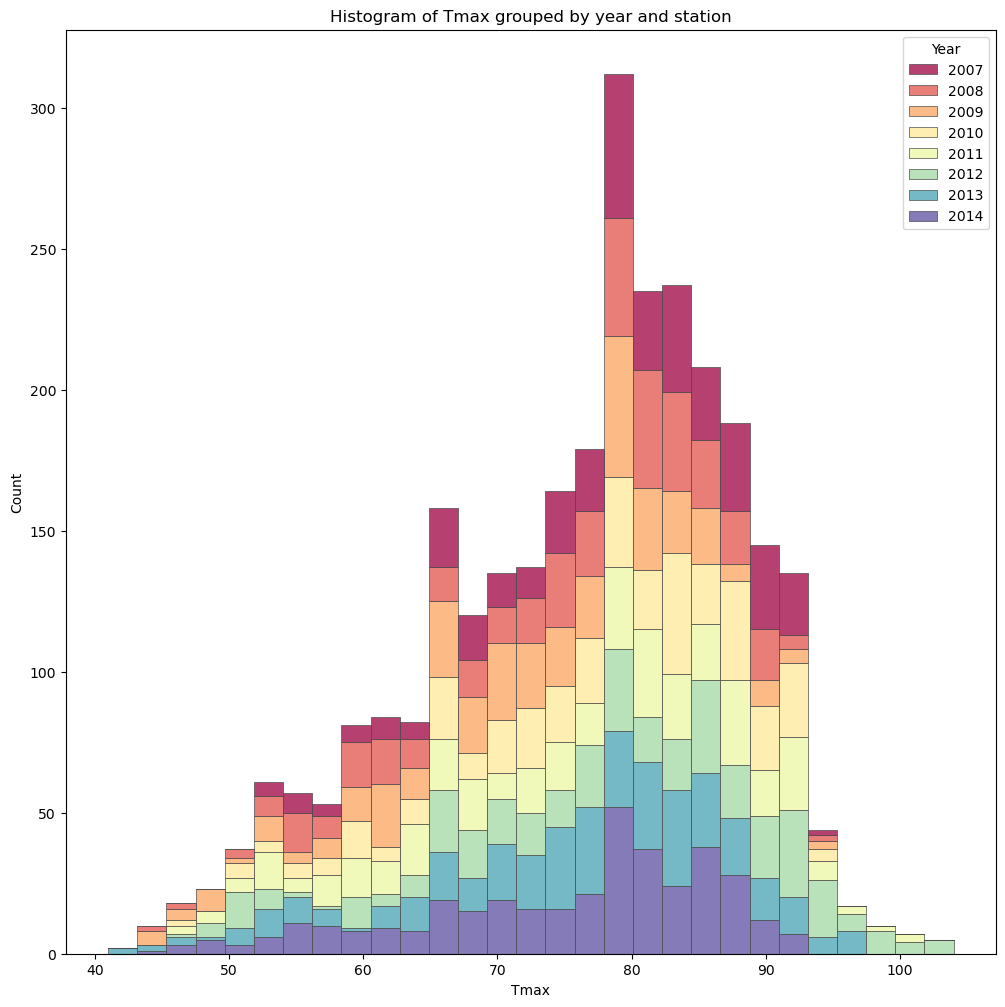

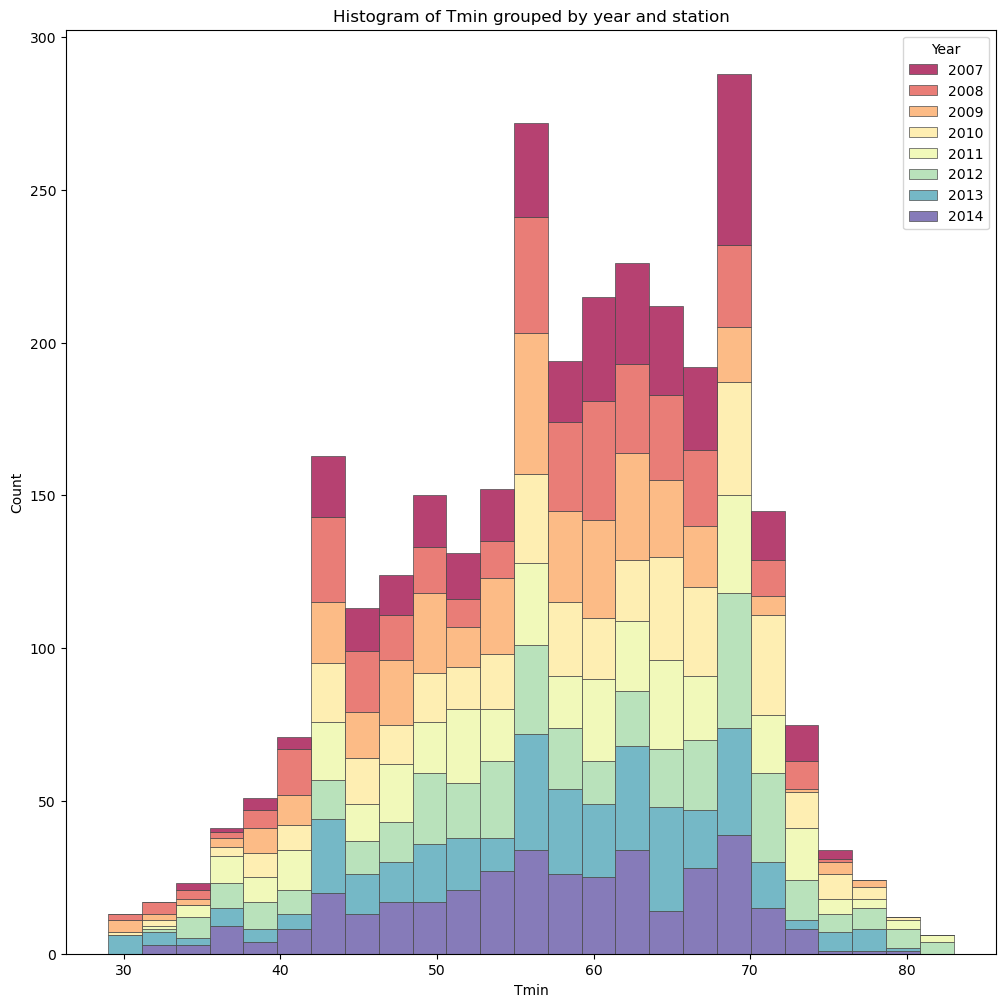

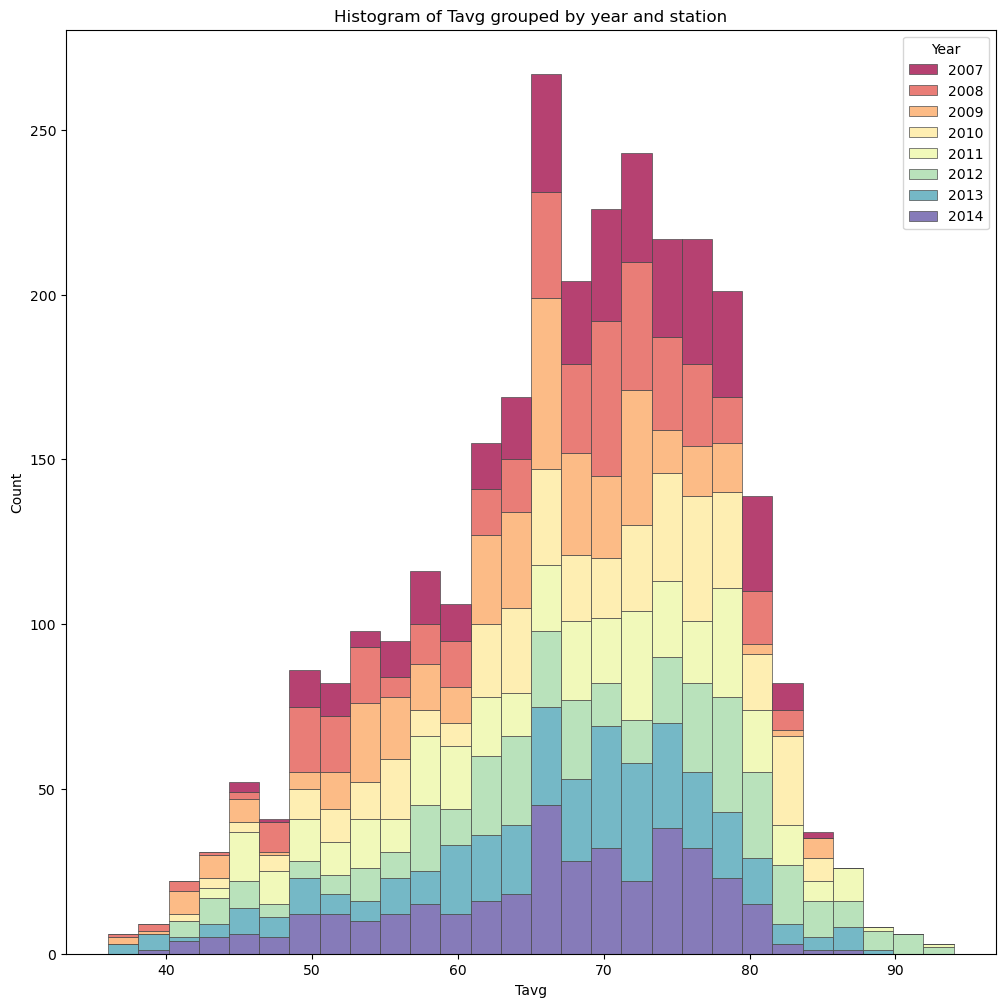

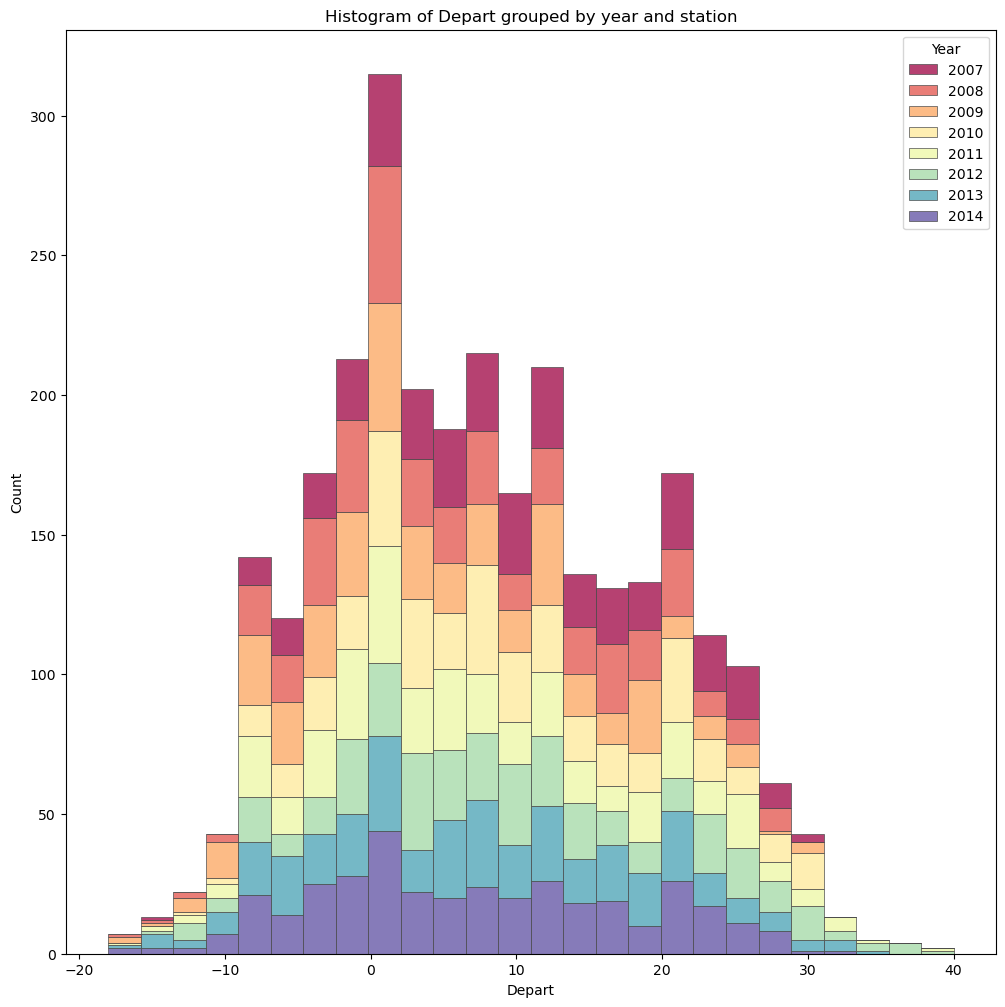

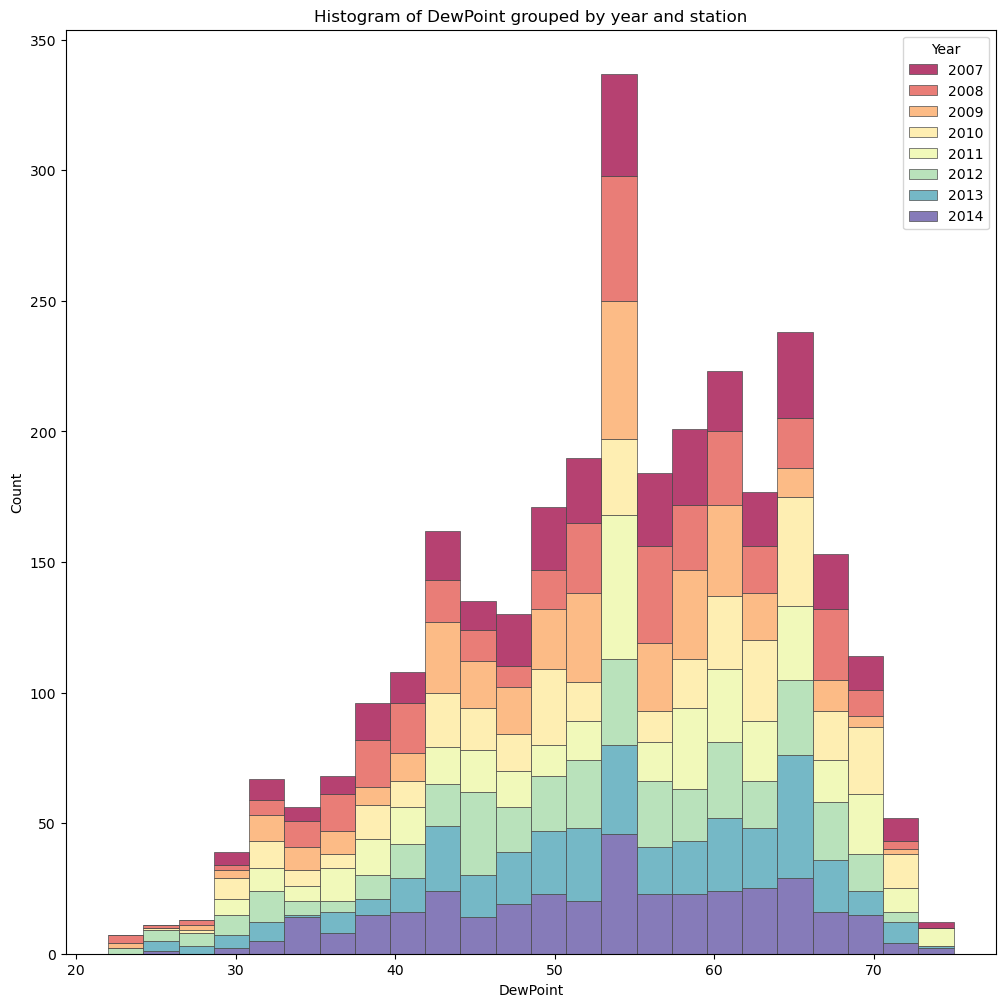

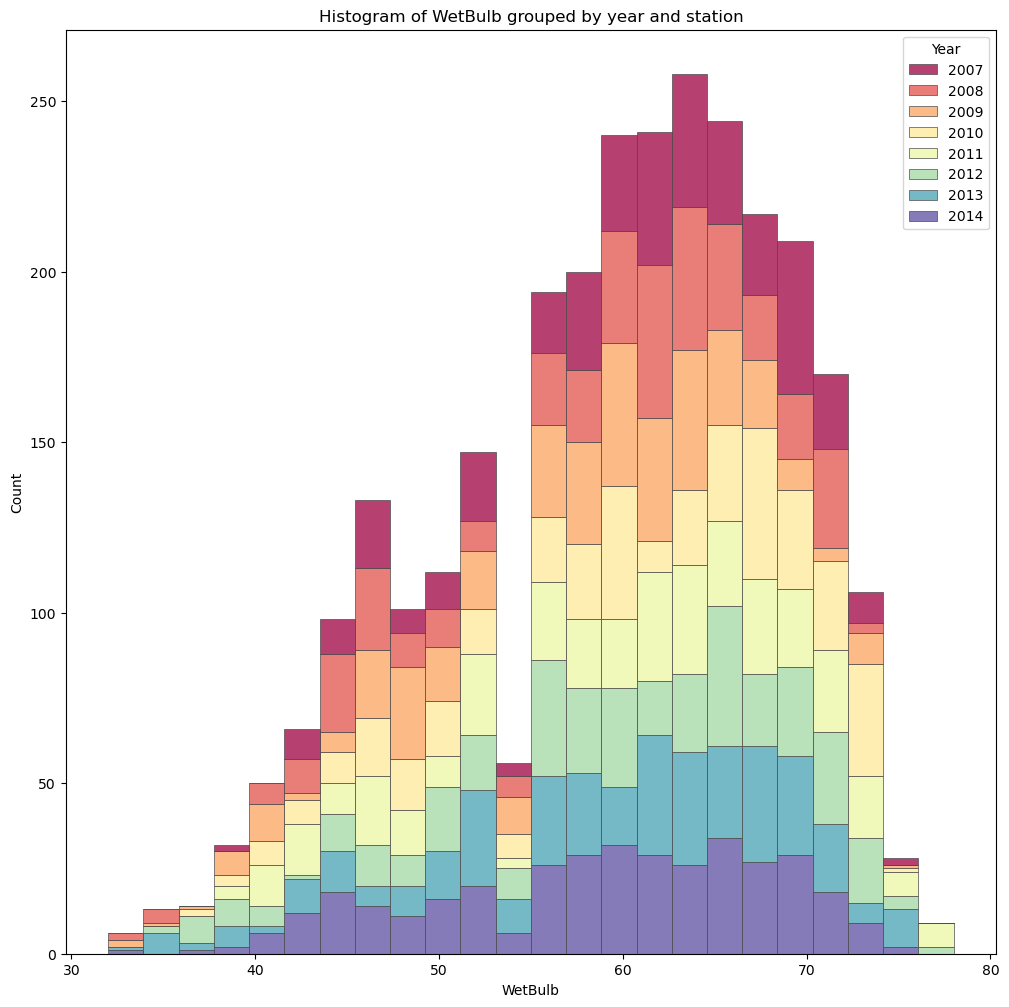

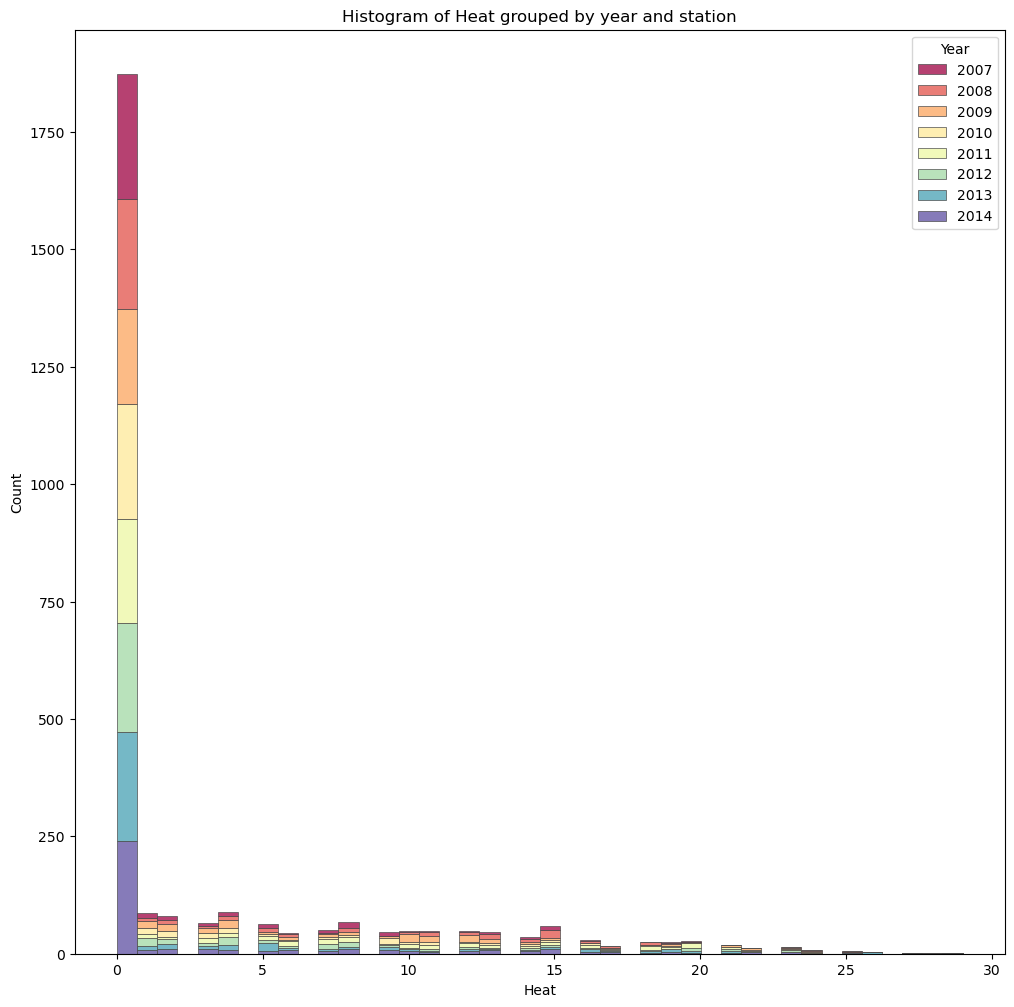

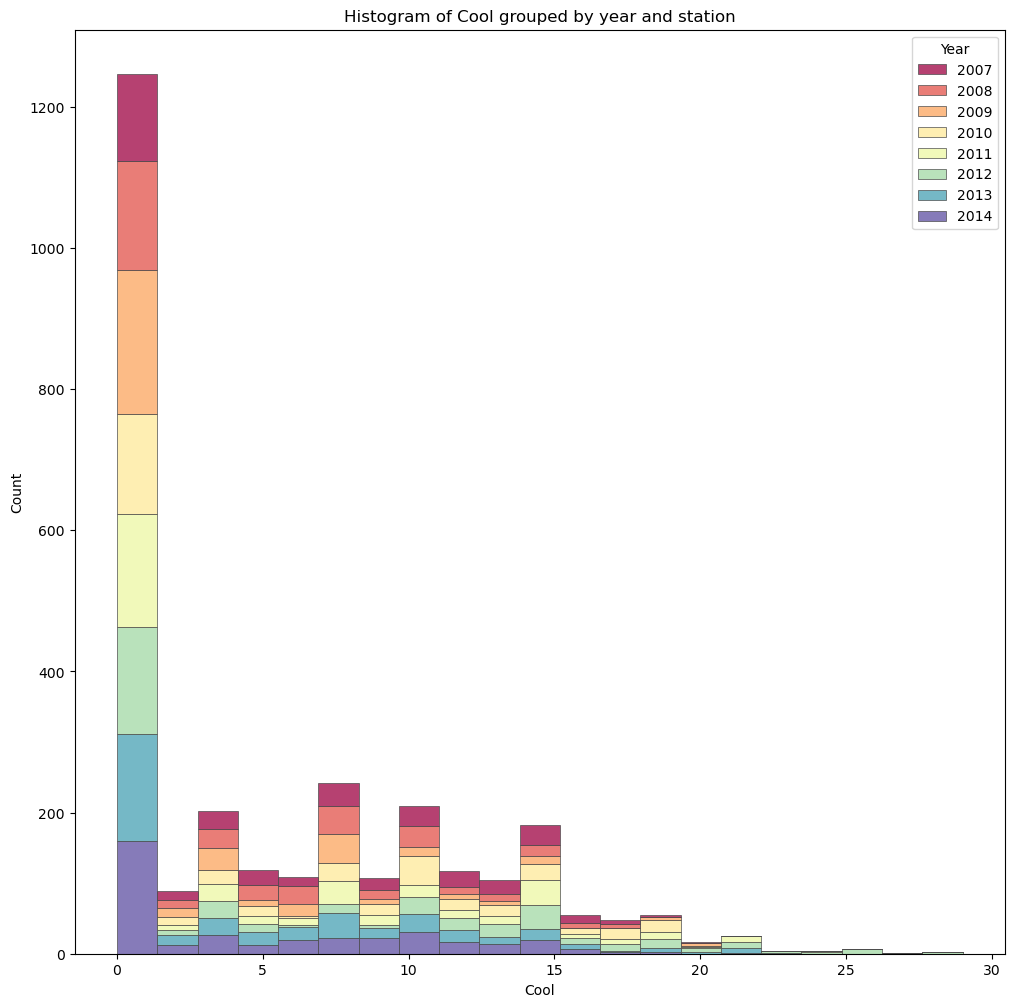

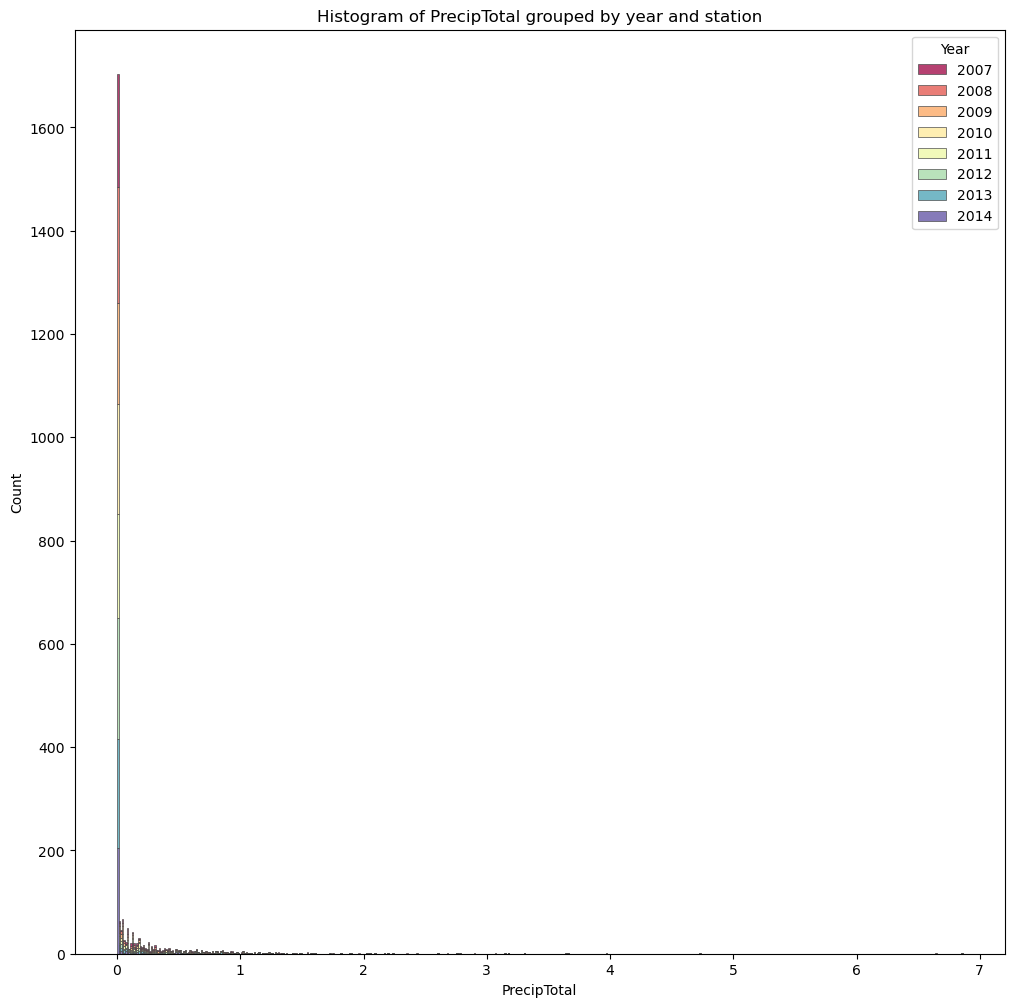

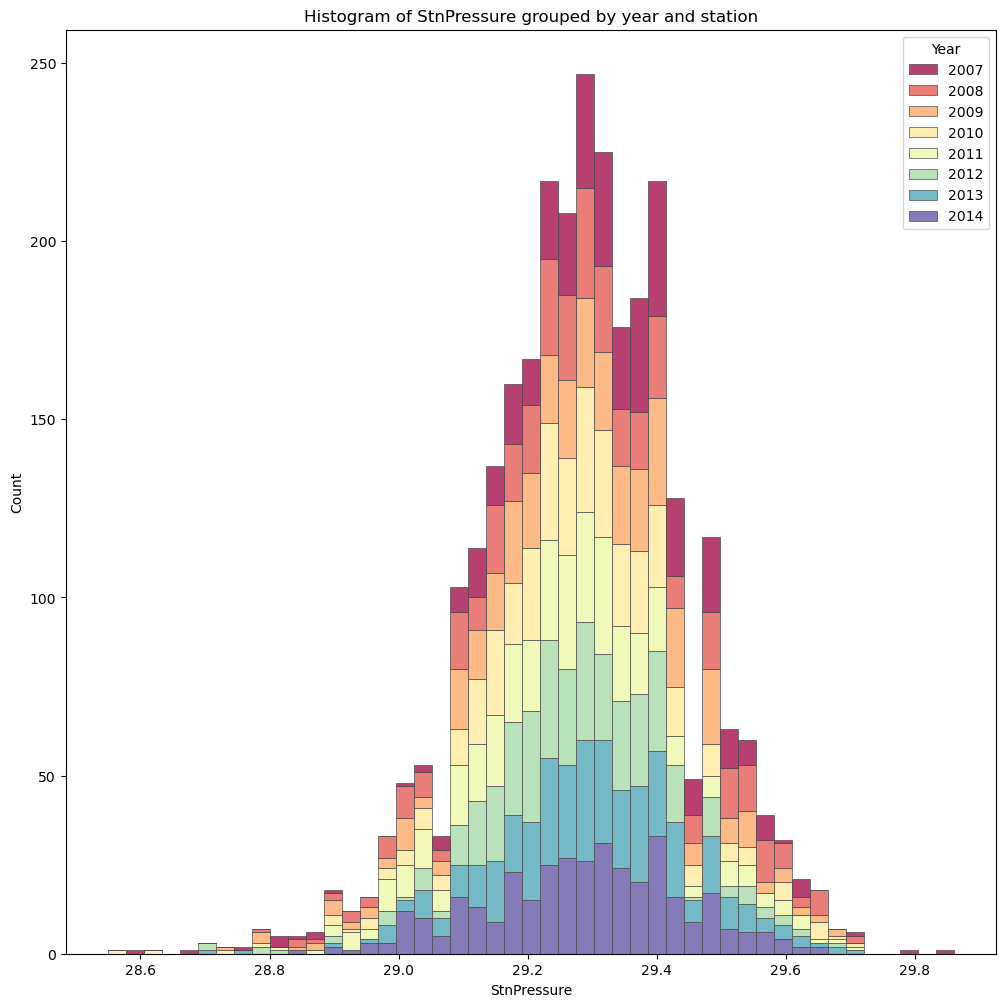

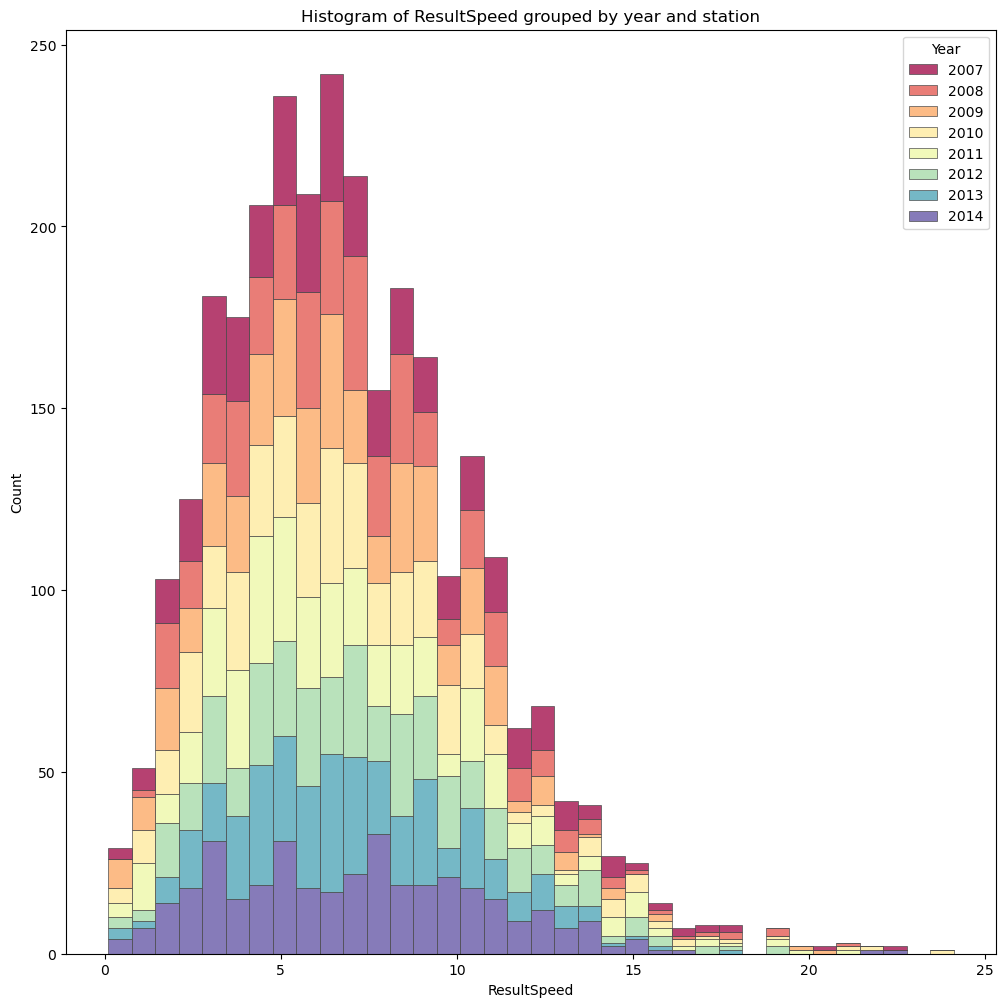

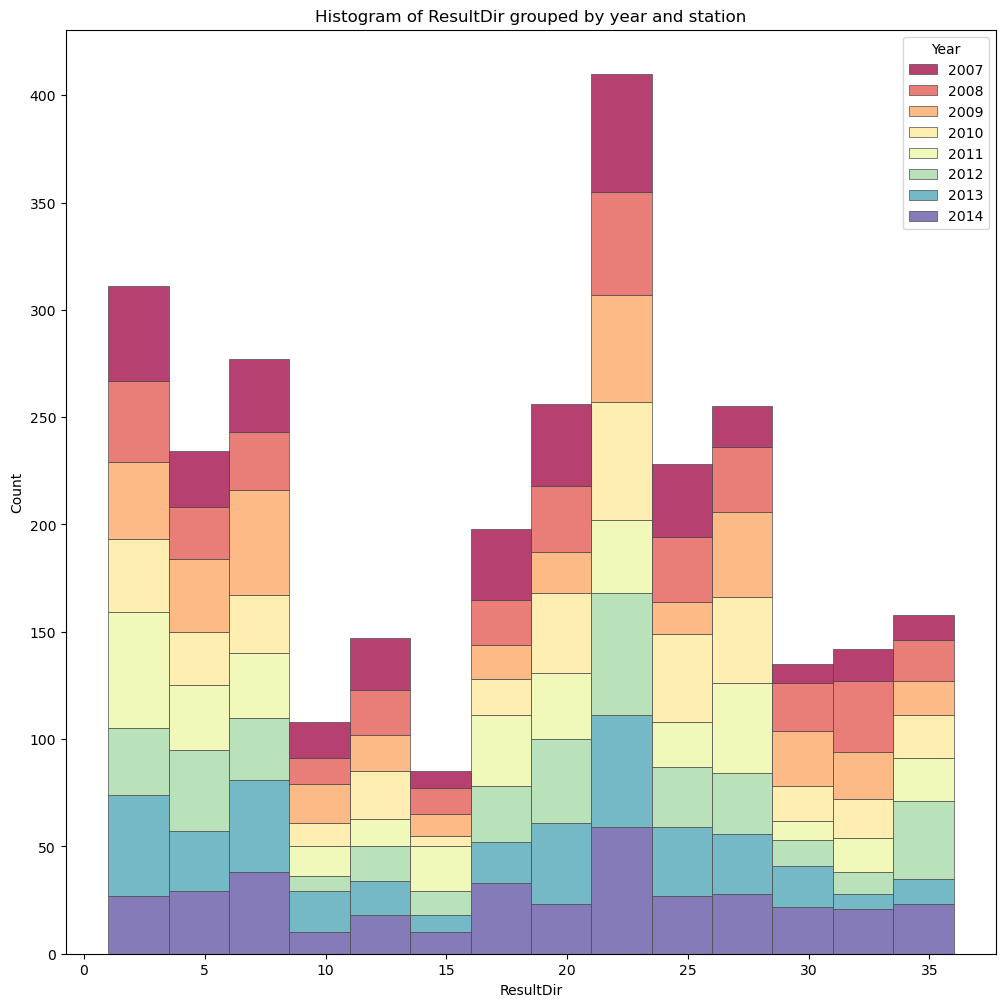

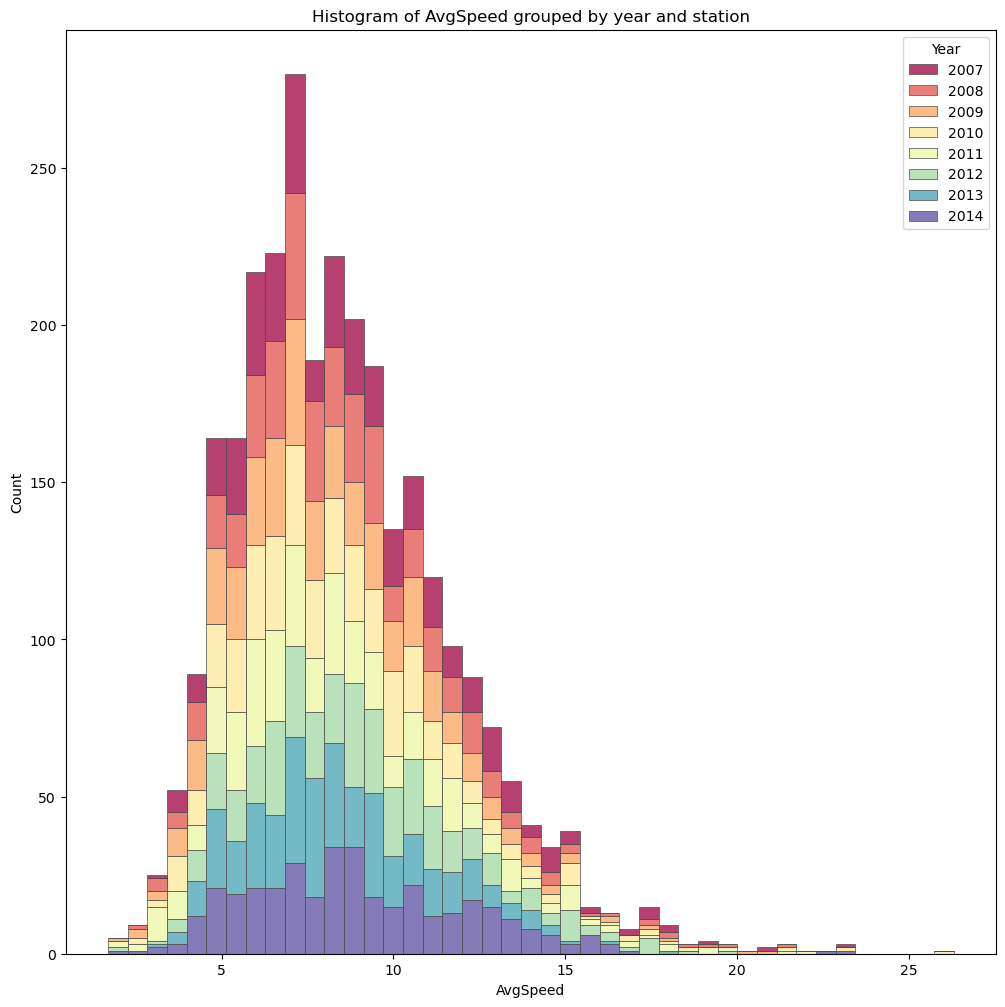

In [41]:

# Copy the DataFrame and add a 'year' column
climate = weather.copy()
climate['Year'] = climate['Date'].dt.year

# Get the numeric columns
numeric_columns = climate.select_dtypes(include=[np.number]).columns.tolist()

# Remove 'year' and 'station' from the list of numeric columns
numeric_columns.remove('Year')
numeric_columns.remove('Station')

# Plot histograms for each numeric column
for col in numeric_columns:
    plt.figure(figsize=(12, 12))
    sb.histplot(data=climate, x=col, hue="Year", multiple="stack", palette="Spectral", edgecolor=".3", linewidth=.5)
    plt.title(f'Histogram of {col} grouped by year and station')
    plt.show()


Weather patterns at both stations show relatively normal distributions, although there are slight left and right skews in temperature and wind speed data. The heating and cooling days show significant skew but this expected because the number of hot and cold days depends both on season and weather conditions. In the modeling process, time variable is also used as an input and this captures the annual variation. Therefore further transformation is not required for the present model.

### Training and Test Data
Training data is provided in: train.csv file and data to predict for is provided in: test.csv. It is vital that same transformations are applied to both training and prediction datasets to be used in models.

Training and prediction datasets have: date, address, species, block, street, trap, streetaddress, lat, lon, and accuracy columns. The training dataset has two additional columns: number of mosquitos, and whether or not WNV is present.

(Description from Kaggle): Every year from late-May to early-October, public health workers in Chicago setup mosquito traps scattered across the city. Every week from Monday through Wednesday, these traps collect mosquitos, and the mosquitos are tested for the presence of West Nile virus before the end of the week. The test results include the number of mosquitos, the mosquitos species, and whether or not West Nile virus is present in the cohort. These test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50.

The location of the traps are described by the block number and street name. For your convenience, we have mapped these attributes into Longitude and Latitude in the dataset. Please note that these are derived locations. For example, Block=79, and Street= "W FOSTER AVE" gives us an approximate address of "7900 W FOSTER AVE, Chicago, IL", which translates to (41.974089,-87.824812) on the map.

Some traps are "satellite traps". These are traps that are set up near (usually within 6 blocks) an established trap to enhance surveillance efforts. Satellite traps are postfixed with letters. For example, T220A is a satellite trap to T220. 

It is to be noted that not all the locations are tested at all times, and records exist only when a particular species of mosquitos is found at a certain trap at a certain time.

Field Descriptions:
1. Date: date that the WNV test is performed
2. Address: approximate address of the location of trap. This is used to send to the GeoCoder. 
3. Species: the species of mosquitos
4. Block: block number of address
5. Street: street name
6. Trap: Id of the trap
7. AddressNumberAndStreet: approximate address returned from GeoCoder
8. Latitude, Longitude: Latitude and Longitude returned from GeoCoder
9. AddressAccuracy: accuracy returned from GeoCoder
10. NumMosquitos: number of mosquitoes caught in this trap
11. WnvPresent: whether West Nile Virus was present in these mosquitos. 1 means WNV is present, and 0 means not present. 

In [42]:
# training data
train = pd.read_csv('train.csv')

# convert to datetime
train.Date = pd.to_datetime(train.Date)

# Data to predict
test = pd.read_csv('test.csv')

# convert to datetime
test.Date = pd.to_datetime(test.Date)

# Reset index
test.reset_index(inplace=True)

In [43]:
train.head()

Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2 2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   NumMosquitos  WnvPresent  
0             1           0  
1             1           0  
2             1           0  
3             1           0  
4             4           0

In [44]:
test.tail()

index      Id       Date  \
116288  116288  116289 2014-10-02   
116289  116289  116290 2014-10-02   
116290  116290  116291 2014-10-02   
116291  116291  116292 2014-10-02   
116292  116292  116293 2014-10-02   

                                                Address            Species  \
116288  2100 North Cannon Drive, Chicago, IL 60614, USA   CULEX SALINARIUS   
116289  2100 North Cannon Drive, Chicago, IL 60614, USA    CULEX TERRITANS   
116290  2100 North Cannon Drive, Chicago, IL 60614, USA     CULEX TARSALIS   
116291  2100 North Cannon Drive, Chicago, IL 60614, USA  UNSPECIFIED CULEX   
116292  2100 North Cannon Drive, Chicago, IL 60614, USA    CULEX ERRATICUS   

        Block        Street   Trap          AddressNumberAndStreet   Latitude  \
116288     21   N CANNON DR  T054C  2100  N CANNON DR, Chicago, IL  41.925652   
116289     21   N CANNON DR  T054C  2100  N CANNON DR, Chicago, IL  41.925652   
116290     21   N CANNON DR  T054C  2100  N CANNON DR, Chicago, IL  41.925652   
116291     21   N CANNON DR  T054C  2100  N CANNON DR, Chicago, IL  41.925652   
116292     21   N CANNON DR  T054C  2100  N CANNON DR, Chicago, IL  41.925652   

        Longitude  AddressAccuracy  
116288  -87.63359                8  
116289  -87.63359                8  
116290  -87.63359                8  
116291  -87.63359                8  
116292  -87.63359                8

#### Time
Time is probably the most important feature for prediction for this data. Time has influence on the instance in a day when mosquitos might be prevalent, or the instance in a year when the climatic conditions are ideal for development of mosquitos. In the current datasets, time refers to the day of the year. All datasets have date represented by year-month-day, but they lack information regarding hour/minute/seconds of observation. Since this information is missing, time in the present context refers to the time of the year represented by year-month-day.

Month and day are cyclic in nature. For example, December 31, 2007 is closer to January 1, 2008 than to June 1, 2007. This means that there is an annual pattern. For modeling, this cyclic nature has to be captures as this has influence on the weather, and potentially influx of mosquitos. Cyclical transformation is applied to date to capture this nature. It is important to note that for this transformation the year has no significance, which means that months have a cyclic behaviour where as years increase monotonically. 

For this transformation, date is converted to julian day, which represents the day number in a year. Cyclic transformation then transforms this julian day into two new features using:

var_sin = sin(variable * (2. * pi / max_value))

var_cos = cos(variable * (2. * pi / max_value))

In [45]:
def cyclic_transform(df):
    # Calculate the day of the year and whether it's a leap year
    df['day_of_year'] = df['Date'].dt.dayofyear
    df['is_leap_year'] = df['Date'].dt.is_leap_year

    # Calculate the maximum value for each row
    df['max_val'] = np.where(df['is_leap_year'], 366, 365)

    # Perform the cyclic transformation
    df['sin_jday'] = np.sin(2 * np.pi * df['day_of_year'] / df['max_val'])
    df['cos_jday'] = np.cos(2 * np.pi * df['day_of_year'] / df['max_val'])

    # Drop the intermediate columns
    df = df.drop(columns=['day_of_year', 'is_leap_year', 'max_val'])

    return df

In [46]:
# apply transformation
train = cyclic_transform(train)
predict = cyclic_transform(test)

In [47]:
# Load map data
mapdata = np.loadtxt('../data/mapdata_copyright_openstreetmap_contributors.txt')

# set bounds - (left, right, bottom, top)
mapregion = (-88, -87.5, 41.6, 42.1)

# map aspect
aspect = mapdata.shape[0] / mapdata.shape[1]

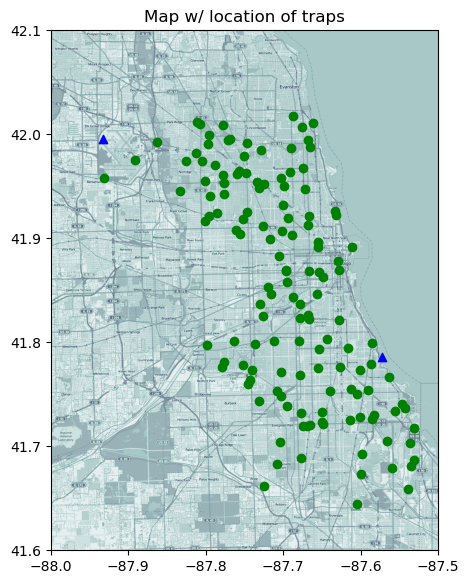

In [48]:
# Plot map w/ trap locations and station location
plt.figure(figsize=(5,9))

# Change the color map to 'hot' for the mapdata
plt.imshow(mapdata, cmap=plt.get_cmap('bone'), extent=mapregion, aspect=aspect)
plt.title('Map w/ location of traps')

# Plot weather stations with a custom color, e.g., 'green'
plt.scatter([-87.933, -87.572], [41.995, 41.786], marker='^', color='Blue')

# Trap locations with a custom color, e.g., 'red'
trapcoords = train[['Longitude', 'Latitude']].drop_duplicates().values
plt.scatter(trapcoords[:,0], trapcoords[:,1], marker='o', color='green')

In [49]:
train.head()

Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2 2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   NumMosquitos  WnvPresent  sin_jday  cos_jday  
0             1           0   0.54524  -0.83828  
1             1           0   0.54524  -0.83828  
2             1           0   0.54524  -0.83828  
3             1           0   0.54524  -0.83828  
4             4           0   0.54524  -0.83828

In [50]:
predict.head()

index  Id       Date                                            Address  \
0      0   1 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1      1   2 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2      2   3 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
3      3   4 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
4      4   5 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2           CULEX PIPIENS     41   N OAK PARK AVE  T002   
3        CULEX SALINARIUS     41   N OAK PARK AVE  T002   
4         CULEX TERRITANS     41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   
2  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   
3  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   
4  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9   

   sin_jday  cos_jday  
0  0.336637 -0.941634  
1  0.336637 -0.941634  
2  0.336637 -0.941634  
3  0.336637 -0.941634  
4  0.336637 -0.941634

#### Location and Species Encoding
Location for each trap is indicated by address, block, street, trap, streetaddress, accuracy, lon, lat. The address, block, street, and streetaddress report same information in that the streetadress can be inferred from the other variables. The address is geocoded to infer latitude and longitude of the trap along with accuracy of geocoding. Therefore the latitude and longitude information is sufficent to capture the spatial variability of the mosquito traps. Although the accuracy column is important from a geocoding perspective, it does not add significant information for prediction modeling. This is because of the potential accuracy errors of trap locations in the prediction datatset. Therefore, the address fields are discarded retaining the latitude and longitude information for each record.

Species is another vital feature that needs to be represented accurately in the model. There are 8 unique classes of mosquito species in the training and prediction datasets: CULEX ERRATICUS, CULEX PIPIENS, CULEX RESTUANS, CULEX PIPIENS/RESTUANS, CULEX SALINARIUS, CULEX TARSALIS, CULEX TERRITANS, UNSPECIFIED CULEX

The species type CULEX PIPIENS/RESTUANS implies that mosquitos of both species are present in the observation or that it is hard to differentiate between both species since ratio of the species is not specified.

Species engineering involves encoding the species type in the training and prediction datasets by creating new features corresponding to the species type. In this approach 7 new feature columns are created corresponding to each of the 7 species using MultiLabelBinarizer. For records with CULEX PIPIENS/RESTUANS, fields corresponding to PIPIENS and RESTUANS are encoded.

In [51]:
# Species
train.Species.unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

In [52]:
predict.Species.unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'UNSPECIFIED CULEX', 'CULEX ERRATICUS'], dtype=object)

In [53]:
from sklearn.preprocessing import MultiLabelBinarizer
#%% Convert species labels for encoding
def species_labels(species):
    return species.replace('CULEX', '').strip().split('/')

#%% Multilabel binarizer for species
def species_encode():
    return MultiLabelBinarizer().fit([['ERRATICUS', 'PIPIENS', 'RESTUANS', 'SALINARIUS', 
           'TARSALIS', 'TERRITANS', 'UNSPECIFIED']])

In [54]:
train['Species']   = train['Species'].apply(species_labels)
predict['Species'] = predict['Species'].apply(species_labels)

In [55]:
mlb = species_encode()
train[mlb.classes_] = mlb.transform(train['Species'])

train.head(3)

Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2 2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   

               Species  Block           Street  Trap  \
0  [PIPIENS, RESTUANS]     41   N OAK PARK AVE  T002   
1           [RESTUANS]     41   N OAK PARK AVE  T002   
2           [RESTUANS]     62    N MANDELL AVE  T007   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   

   ...  WnvPresent  sin_jday  cos_jday  ERRATICUS  PIPIENS  RESTUANS  \
0  ...           0   0.54524  -0.83828          0        1         1   
1  ...           0   0.54524  -0.83828          0        0         1   
2  ...           0   0.54524  -0.83828          0        0         1   

   SALINARIUS  TARSALIS  TERRITANS  UNSPECIFIED  
0           0         0          0            0  
1           0         0          0            0  
2           0         0          0            0  

[3 rows x 21 columns]

In [56]:
predict[mlb.classes_] = mlb.transform(predict['Species'])
predict.head(3)

index  Id       Date                                            Address  \
0      0   1 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1      1   2 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2      2   3 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   

               Species  Block           Street  Trap  \
0  [PIPIENS, RESTUANS]     41   N OAK PARK AVE  T002   
1           [RESTUANS]     41   N OAK PARK AVE  T002   
2            [PIPIENS]     41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  ...  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.95469  ...                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.95469  ...                9   
2  4100  N OAK PARK AVE, Chicago, IL  41.95469  ...                9   

   sin_jday  cos_jday  ERRATICUS  PIPIENS  RESTUANS  SALINARIUS  TARSALIS  \
0  0.336637 -0.941634          0        1         1           0         0   
1  0.336637 -0.941634          0        0         1           0         0   
2  0.336637 -0.941634          0        1         0           0         0   

   TERRITANS  UNSPECIFIED  
0          0            0  
1          0            0  
2          0            0  

[3 rows x 21 columns]

In [57]:
from sklearn.preprocessing import MultiLabelBinarizer, RobustScaler
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from math import radians, cos, sin, asin, sqrt
from scipy.spatial import cKDTree
from tqdm import tqdm

The code consists of two functions: haversine_distance and closest.

haversine_distance(lon1, lat1, lon2, lat2): This function calculates the haversine distance between two points on the earth specified by longitude and latitude. The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes. The function takes four arguments: the longitudes and latitudes of two points. It returns the haversine distance between these two points.
closest(longitude, latitude): This function returns the closest weather station given a pair of coordinates (longitude, latitude). The stations are marked with their respective coordinates. The function calculates the haversine distance from the input coordinates to each station and returns the station number that has the minimum distance to the input coordinates. The function takes two arguments: the longitude and latitude of a point. It returns the number of the closest station to this point.

In [58]:
def haversine_distance(lon1, lat1, lon2, lat2):
    """
    Calculate the haversine distance between two points on the earth specified by longitude and latitude.
    The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes.
    """
    # Convert all longitudes and latitudes from degrees to radians
    lon1, lat1, lon2, lat2 = np.deg2rad([lon1, lat1, lon2, lat2])

    # Calculate differences
    delta_lat, delta_lon = lat2 - lat1, lon2 - lon1

    # Haversine formula
    a = np.sin(delta_lat / 2.)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(delta_lon / 2.)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Radius of Earth in kilometers
    radius_of_earth = 6371

    # Return the haversine distance
    return radius_of_earth * c


def closest(longitude, latitude):
    """
    Given a pair of coordinates (longitude, latitude), this function returns the closest weather station.
    The stations are hardcoded with their respective coordinates.
    """
    
    # Dictionary of weather stations with their respective coordinates
    # Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT 
    # Station 2: CHICAGO MIDWAY INTL ARPT
    stations = {1: [-87.933, 41.995],  # Coordinates for Station 1
                2: [-87.752, 41.786]}  # Coordinates for Station 2

    # Calculate the haversine distance from the input coordinates to each station
    distances = np.array([haversine_distance(stations[1][0], stations[1][1], longitude, latitude),
                          haversine_distance(stations[2][0], stations[2][1], longitude, latitude)])

    # Return the station number that has the minimum distance to the input coordinates
    closest_station = 1 if distances.argmin() == 0 else 2
    return closest_station

In [59]:
train['closest_station']   = train[['Latitude', 'Longitude']].apply(lambda x: closest(x['Longitude'], x['Latitude']), axis=1)
predict['closest_station'] = predict[['Latitude', 'Longitude']].apply(lambda x: closest(x['Longitude'], x['Latitude']), axis=1)

The `add_weather_data` function adds weather data to both the training and predict dataset. It takes four parameters: `x` (the input data), `weather` (the weather data), `columns`, and `days` (the number of days to look back for weather data).

The function works as follows:
1. It retrieves the closest station and the date from the input data `x`.
2. It initializes an empty list `output` to store the weather data.
3. It loops over the specified `days`, and for each day, it calculates the start date by subtracting the number of days from the given date.
4. It creates a mask to filter the weather data for the specified station and dates.
5. It applies the mask to the weather data and selects the specified columns.
6. It calculates the mean of the selected weather data.
7. It appends the mean values to the `output` list.
8. Finally, it returns the `output` list containing the weather data.

The `weather_columns` list contains the names of the weather-related columns to be considered from the weather data.

The `days` list specifies the number of days to look back for weather data.

The `output_columns` list is created by combining each weather column name with each day, indicating the weather data for that day. For example, 'Tmax_0' would represent the maximum temperature for the current day, 'Tmax_2' would represent the maximum temperature for two days ago, and so on. This list will be used as column names when the output from `add_weather_data` is added to a DataFrame.

In [60]:
def add_weather_data(x, weather, columns, days=[0, 2, 4,]):
    station = x['closest_station']
    date    = x['Date']

    output = []

    # Loop days
    for day in days:
        # get min and max dates based on day
        start_date = date - pd.Timedelta(day, unit='days')

        #print(f'Getting weather information for station: {station} from {start_date} to {date}')
        # Get weather for number of days defined by day
        mask = (weather['Station']==station) & (weather['Date']>=start_date) & (weather['Date']<=date)
        temp = weather.loc[mask, columns]

        # Now get mean of weather
        temp = temp.mean()

        # Append it to a list
        output += list(temp.values)
        
        #print('Done fetching weather')
    
    return output

In [61]:
weather_columns = ['Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 
                   'Heat', 'Cool', 'StnPressure', 'ResultSpeed', 'ResultDir', 'AvgSpeed']

days = [0, 2, 4]

output_columns = [f'{x}_{y}' for y in days for x in weather_columns]

In [108]:
train[output_columns] = train[['Date', 'closest_station']].apply(lambda x: add_weather_data(x, weather, weather_columns, days=days), axis=1, result_type='expand')
train[output_columns]

Tmax_0  Tmin_0  Tavg_0  Depart_0  DewPoint_0  WetBulb_0  Heat_0  \
0        88.0    60.0    74.0      10.0        58.0       65.0     0.0   
1        88.0    60.0    74.0      10.0        58.0       65.0     0.0   
2        88.0    60.0    74.0      10.0        58.0       65.0     0.0   
3        88.0    60.0    74.0      10.0        58.0       65.0     0.0   
4        88.0    60.0    74.0      10.0        58.0       65.0     0.0   
...       ...     ...     ...       ...         ...        ...     ...   
10501    75.0    55.0    65.0      11.0        52.0       58.0     0.0   
10502    75.0    50.0    63.0       3.0        52.0       58.0     2.0   
10503    75.0    55.0    65.0      11.0        52.0       58.0     0.0   
10504    75.0    50.0    63.0       3.0        52.0       58.0     2.0   
10505    75.0    55.0    65.0      11.0        52.0       58.0     0.0   

       Cool_0  StnPressure_0  ResultSpeed_0  ...  Tavg_4  Depart_4  \
0         9.0          29.39            5.8  ...    65.0       2.4   
1         9.0          29.39            5.8  ...    65.0       2.4   
2         9.0          29.39            5.8  ...    65.0       2.4   
3         9.0          29.39            5.8  ...    65.0       2.4   
4         9.0          29.39            5.8  ...    65.0       2.4   
...       ...            ...            ...  ...     ...       ...   
10501     0.0          29.40            4.1  ...    63.6       9.6   
10502     0.0          29.34            3.8  ...    59.8      -1.2   
10503     0.0          29.40            4.1  ...    63.6       9.6   
10504     0.0          29.34            3.8  ...    59.8      -1.2   
10505     0.0          29.40            4.1  ...    63.6       9.6   

       DewPoint_4  WetBulb_4  Heat_4  Cool_4  StnPressure_4  ResultSpeed_4  \
0            50.2       57.2     2.0     2.0         29.406           5.44   
1            50.2       57.2     2.0     2.0         29.406           5.44   
2            50.2       57.2     2.0     2.0         29.406           5.44   
3            50.2       57.2     2.0     2.0         29.406           5.44   
4            50.2       57.2     2.0     2.0         29.406           5.44   
...           ...        ...     ...     ...            ...            ...   
10501        48.2       54.2     3.8     0.0         29.358           5.48   
10502        49.6       54.6     5.2     0.0         29.294           5.18   
10503        48.2       54.2     3.8     0.0         29.358           5.48   
10504        49.6       54.6     5.2     0.0         29.294           5.18   
10505        48.2       54.2     3.8     0.0         29.358           5.48   

       ResultDir_4  AvgSpeed_4  
0             15.2        7.46  
1             15.2        7.46  
2             15.2        7.46  
3             15.2        7.46  
4             15.2        7.46  
...            ...         ...  
10501          8.0        6.66  
10502          7.4        6.30  
10503          8.0        6.66  
10504          7.4        6.30  
10505          8.0        6.66  

[10506 rows x 36 columns]

In [109]:
predict[output_columns] = predict[['Date', 'closest_station']].apply(lambda x: add_weather_data(x, weather, weather_columns, days=days), axis=1, result_type='expand')
predict[output_columns]

Tmax_0  Tmin_0  Tavg_0  Depart_0  DewPoint_0  WetBulb_0  Heat_0  \
0         86.0    61.0    74.0       7.0        56.0       64.0     0.0   
1         86.0    61.0    74.0       7.0        56.0       64.0     0.0   
2         86.0    61.0    74.0       7.0        56.0       64.0     0.0   
3         86.0    61.0    74.0       7.0        56.0       64.0     0.0   
4         86.0    61.0    74.0       7.0        56.0       64.0     0.0   
...        ...     ...     ...       ...         ...        ...     ...   
116288    75.0    66.0    71.0      17.0        63.0       65.0     0.0   
116289    75.0    66.0    71.0      17.0        63.0       65.0     0.0   
116290    75.0    66.0    71.0      17.0        63.0       65.0     0.0   
116291    75.0    66.0    71.0      17.0        63.0       65.0     0.0   
116292    75.0    66.0    71.0      17.0        63.0       65.0     0.0   

        Cool_0  StnPressure_0  ResultSpeed_0  ...  Tavg_4  Depart_4  \
0          9.0          29.28            8.9  ...    73.0       6.6   
1          9.0          29.28            8.9  ...    73.0       6.6   
2          9.0          29.28            8.9  ...    73.0       6.6   
3          9.0          29.28            8.9  ...    73.0       6.6   
4          9.0          29.28            8.9  ...    73.0       6.6   
...        ...            ...            ...  ...     ...       ...   
116288     6.0          29.10            7.2  ...    66.0      12.0   
116289     6.0          29.10            7.2  ...    66.0      12.0   
116290     6.0          29.10            7.2  ...    66.0      12.0   
116291     6.0          29.10            7.2  ...    66.0      12.0   
116292     6.0          29.10            7.2  ...    66.0      12.0   

        DewPoint_4  WetBulb_4  Heat_4  Cool_4  StnPressure_4  ResultSpeed_4  \
0             63.0       66.8     0.0     8.0         29.166           8.60   
1             63.0       66.8     0.0     8.0         29.166           8.60   
2             63.0       66.8     0.0     8.0         29.166           8.60   
3             63.0       66.8     0.0     8.0         29.166           8.60   
4             63.0       66.8     0.0     8.0         29.166           8.60   
...            ...        ...     ...     ...            ...            ...   
116288        55.4       59.4     2.2     3.2         29.302           6.28   
116289        55.4       59.4     2.2     3.2         29.302           6.28   
116290        55.4       59.4     2.2     3.2         29.302           6.28   
116291        55.4       59.4     2.2     3.2         29.302           6.28   
116292        55.4       59.4     2.2     3.2         29.302           6.28   

        ResultDir_4  AvgSpeed_4  
0              20.4       10.54  
1              20.4       10.54  
2              20.4       10.54  
3              20.4       10.54  
4              20.4       10.54  
...             ...         ...  
116288         14.8        7.90  
116289         14.8        7.90  
116290         14.8        7.90  
116291         14.8        7.90  
116292         14.8        7.90  

[116293 rows x 36 columns]

In [110]:
## Save processed data
train.to_pickle('train_processed.pkl')
predict.to_pickle('predict_processed.pkl')

In [111]:
# Load saved data
train   = pd.read_pickle('train_processed.pkl')
predict = pd.read_pickle('predict_processed.pkl')

In [112]:
train.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'sin_jday', 'cos_jday', 'ERRATICUS',
       'PIPIENS', 'RESTUANS', 'SALINARIUS', 'TARSALIS', 'TERRITANS',
       'UNSPECIFIED', 'closest_station', 'Tmax_0', 'Tmin_0', 'Tavg_0',
       'Depart_0', 'DewPoint_0', 'WetBulb_0', 'Heat_0', 'Cool_0',
       'StnPressure_0', 'ResultSpeed_0', 'ResultDir_0', 'AvgSpeed_0', 'Tmax_2',
       'Tmin_2', 'Tavg_2', 'Depart_2', 'DewPoint_2', 'WetBulb_2', 'Heat_2',
       'Cool_2', 'StnPressure_2', 'ResultSpeed_2', 'ResultDir_2', 'AvgSpeed_2',
       'Tmax_4', 'Tmin_4', 'Tavg_4', 'Depart_4', 'DewPoint_4', 'WetBulb_4',
       'Heat_4', 'Cool_4', 'StnPressure_4', 'ResultSpeed_4', 'ResultDir_4',
       'AvgSpeed_4'],
      dtype='object')

In [113]:
predict.columns

Index(['index', 'Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'sin_jday', 'cos_jday', 'ERRATICUS', 'PIPIENS', 'RESTUANS',
       'SALINARIUS', 'TARSALIS', 'TERRITANS', 'UNSPECIFIED', 'closest_station',
       'year', 'Tmax_0', 'Tmin_0', 'Tavg_0', 'Depart_0', 'DewPoint_0',
       'WetBulb_0', 'Heat_0', 'Cool_0', 'StnPressure_0', 'ResultSpeed_0',
       'ResultDir_0', 'AvgSpeed_0', 'Tmax_2', 'Tmin_2', 'Tavg_2', 'Depart_2',
       'DewPoint_2', 'WetBulb_2', 'Heat_2', 'Cool_2', 'StnPressure_2',
       'ResultSpeed_2', 'ResultDir_2', 'AvgSpeed_2', 'Tmax_4', 'Tmin_4',
       'Tavg_4', 'Depart_4', 'DewPoint_4', 'WetBulb_4', 'Heat_4', 'Cool_4',
       'StnPressure_4', 'ResultSpeed_4', 'ResultDir_4', 'AvgSpeed_4'],
      dtype='object')

We have scaled certain features in a dataset using the RobustScaler. It ignores specific columns, fits the scaler on the training data, and then applies the scaling to both the training and prediction datasets. This process helps improve machine learning model performance.

In [114]:
ignore_columns = ['Date', 'Address', 'Species', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet', 
                  'AddressAccuracy', 'NumMosquitos', 'WnvPresent','closest_station','Heat_0', 'Cool_0','Tmax_6', 'Tmin_6', 'Tavg_6', 'Depart_6', 'DewPoint_6',
'WetBulb_6', 'Heat_6', 'Cool_6', 'StnPressure_6', 'ResultSpeed_6',
       'ResultDir_6', 'AvgSpeed_6','Heat_2','Cool_2','Depart_4',
       'DewPoint_4', 'WetBulb_4', 'Heat_4', 'Cool_4', 'StnPressure_4',
       'ResultSpeed_4', 'ResultDir_4', 'AvgSpeed_4','Depart_2', 'DewPoint_2',
       'WetBulb_2', 'Heat_2', 'Cool_2', 'StnPressure_2', 'ResultSpeed_2',
       'ResultDir_2', 'AvgSpeed_2','Tmax_0', 'Tmin_0', 'Tavg_0', 'Depart_0', 'DewPoint_0', 'WetBulb_0',
       'Heat_0', 'Cool_0', 'StnPressure_0', 'ResultSpeed_0', 'ResultDir_0',
       'AvgSpeed_0']

# Scaling features (assuming 'features' is your list of feature column names)
scale_columns = [x for x in train.columns if x not in ignore_columns]

# Scaler
scaler = RobustScaler().fit(train[scale_columns])

# Create new df with scaled columns
train_scaled   = train[scale_columns].copy()
predict_scaled = predict[scale_columns].copy()

train_scaled[scale_columns]   = scaler.transform(train[scale_columns])
predict_scaled[scale_columns] = scaler.transform(predict[scale_columns])

### Finalizing Datasets for Modeling and prediction

Training dataset has been processed to include features that are relevant for prediction. The dataset for which probability of presence of virus is to be predicted has also been processed in a similar way to be consistent for modeling.

In [115]:
# Split the data into features and targets (assuming 'target' is your target column name)
X_train = train_scaled.copy()
y_train = train['WnvPresent']

X_train

Latitude  Longitude  sin_jday  cos_jday  ERRATICUS  PIPIENS  RESTUANS  \
0      0.488967  -0.801367  1.796636 -0.022610        0.0      0.0       0.0   
1      0.488967  -0.801367  1.796636 -0.022610        0.0     -1.0       0.0   
2      0.670744  -0.561622  1.796636 -0.022610        0.0     -1.0       0.0   
3      0.576466  -0.981455  1.796636 -0.022610        0.0      0.0       0.0   
4      0.576466  -0.981455  1.796636 -0.022610        0.0     -1.0       0.0   
...         ...        ...       ...       ...        ...      ...       ...   
10501 -0.372340  -0.357674 -0.710748  1.776282        0.0      0.0       0.0   
10502  0.635964   0.218675 -0.710748  1.776282        0.0      0.0       0.0   
10503  0.298954   0.203638 -0.710748  1.776282        0.0      0.0       0.0   
10504  0.737883  -0.848889 -0.710748  1.776282        0.0      0.0       0.0   
10505 -0.315079   0.513291 -0.710748  1.776282        0.0      0.0       0.0   

       SALINARIUS  TARSALIS  TERRITANS  UNSPECIFIED    Tmax_2  Tmin_2  \
0             0.0       0.0        0.0          0.0 -0.166667   -1.04   
1             0.0       0.0        0.0          0.0 -0.166667   -1.04   
2             0.0       0.0        0.0          0.0 -0.166667   -1.04   
3             0.0       0.0        0.0          0.0 -0.166667   -1.04   
4             0.0       0.0        0.0          0.0 -0.166667   -1.04   
...           ...       ...        ...          ...       ...     ...   
10501         0.0       0.0        0.0          0.0 -0.375000   -1.20   
10502         0.0       0.0        0.0          0.0 -1.291667   -1.72   
10503         0.0       0.0        0.0          0.0 -0.375000   -1.20   
10504         0.0       0.0        0.0          0.0 -1.291667   -1.72   
10505         0.0       0.0        0.0          0.0 -0.375000   -1.20   

         Tavg_2  Tmax_4    Tmin_4    Tavg_4  
0     -0.666667   -0.80 -1.268293 -1.105263  
1     -0.666667   -0.80 -1.268293 -1.105263  
2     -0.666667   -0.80 -1.268293 -1.105263  
3     -0.666667   -0.80 -1.268293 -1.105263  
4     -0.666667   -0.80 -1.268293 -1.105263  
...         ...     ...       ...       ...  
10501 -0.833333   -0.95 -1.512195 -1.289474  
10502 -1.541667   -1.50 -1.926829 -1.789474  
10503 -0.833333   -0.95 -1.512195 -1.289474  
10504 -1.541667   -1.50 -1.926829 -1.789474  
10505 -0.833333   -0.95 -1.512195 -1.289474  

[10506 rows x 17 columns]

In [116]:
X_predict = predict_scaled.copy()
X_predict

Latitude  Longitude  sin_jday  cos_jday  ERRATICUS  PIPIENS  RESTUANS  \
0       0.488967  -0.801367  1.457413 -0.268345        0.0      0.0       0.0   
1       0.488967  -0.801367  1.457413 -0.268345        0.0     -1.0       0.0   
2       0.488967  -0.801367  1.457413 -0.268345        0.0      0.0      -1.0   
3       0.488967  -0.801367  1.457413 -0.268345        0.0     -1.0      -1.0   
4       0.488967  -0.801367  1.457413 -0.268345        0.0     -1.0      -1.0   
...          ...        ...       ...       ...        ...      ...       ...   
116288  0.357992   0.464196 -0.715804  2.021631        0.0     -1.0      -1.0   
116289  0.357992   0.464196 -0.715804  2.021631        0.0     -1.0      -1.0   
116290  0.357992   0.464196 -0.715804  2.021631        0.0     -1.0      -1.0   
116291  0.357992   0.464196 -0.715804  2.021631        0.0     -1.0      -1.0   
116292  0.357992   0.464196 -0.715804  2.021631        1.0     -1.0      -1.0   

        SALINARIUS  TARSALIS  TERRITANS  UNSPECIFIED    Tmax_2  Tmin_2  \
0              0.0       0.0        0.0          0.0 -0.291667   -0.32   
1              0.0       0.0        0.0          0.0 -0.291667   -0.32   
2              0.0       0.0        0.0          0.0 -0.291667   -0.32   
3              1.0       0.0        0.0          0.0 -0.291667   -0.32   
4              0.0       0.0        1.0          0.0 -0.291667   -0.32   
...            ...       ...        ...          ...       ...     ...   
116288         1.0       0.0        0.0          0.0 -1.541667   -0.96   
116289         0.0       0.0        1.0          0.0 -1.541667   -0.96   
116290         0.0       1.0        0.0          0.0 -1.541667   -0.96   
116291         0.0       0.0        0.0          1.0 -1.541667   -0.96   
116292         0.0       0.0        0.0          0.0 -1.541667   -0.96   

          Tavg_2  Tmax_4    Tmin_4    Tavg_4  
0      -0.333333   0.000 -0.146341 -0.052632  
1      -0.333333   0.000 -0.146341 -0.052632  
2      -0.333333   0.000 -0.146341 -0.052632  
3      -0.333333   0.000 -0.146341 -0.052632  
4      -0.333333   0.000 -0.146341 -0.052632  
...          ...     ...       ...       ...  
116288 -1.291667  -0.925 -0.975610 -0.973684  
116289 -1.291667  -0.925 -0.975610 -0.973684  
116290 -1.291667  -0.925 -0.975610 -0.973684  
116291 -1.291667  -0.925 -0.975610 -0.973684  
116292 -1.291667  -0.925 -0.975610 -0.973684  

[116293 rows x 17 columns]

This code is performing a **Grid Search** to find the best hyperparameters for a **Logistic Regression** model.The model is trained on `X_train` and `y_train` data.

After training, the model makes predictions on the training data (`X_train`). Then, it calculates several metrics to evaluate the performance of the model:

- **Precision**: This is the ratio of correctly predicted positive observations to the total predicted positives. The precision of the model is approximately **0.109**, which means that when the model predicts an instance is positive, it's correct about 11.8% of the time.

- **Recall**: This is the ratio of correctly predicted positive observations to all actual positives. The recall of the model is approximately **0.833**, which means the model correctly identifies 84.6% of all actual positive instances.

- **F-score**: This is the weighted average of Precision and Recall. It tries to find the balance between precision and recall. The F-score for the  model is approximately **0.193**.

- **Accuracy**: This is the ratio of correctly predicted observations to the total observations. The accuracy of the model is approximately **0.66**, which means the model correctly predicts the class of an instance about 66.1% of the time.

- **ROC AUC**: This score represents the model's ability to distinguish between positive and negative classes. An ROC AUC of **0.729** indicates a reasonably good model.

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# Define the parameter grid
param_grid = {
    'C': [1, 10, 100, 1000],
    'penalty': ['l1','l2'],
    'solver': ['saga']
}

# Create a base model
logreg = LogisticRegression(random_state=45, class_weight='balanced', max_iter=10000, verbose=0, n_jobs=-1)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='precision')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Predict on the train data
y_pred_lg= grid_search.predict(X_train)

# Calculate metrics
precision = precision_score(y_train, y_pred_lg)
recall = recall_score(y_train, y_pred_lg)
fscore = f1_score(y_train, y_pred_lg)
accuracy = accuracy_score(y_train, y_pred_lg)
roc_auc = roc_auc_score(y_train, y_pred_lg)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F-score: {fscore}')
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')


Precision: 0.10975609756097561
Recall: 0.8330308529945554
F-score: 0.19395732093809423
Accuracy: 0.6368741671425852
ROC AUC: 0.7295239649201808


 The model has high recall but low precision. This means it's good at identifying positive instances but has a high false-positive rate. The overall accuracy and ROC AUC scores suggest that the model's performance is fairly good. However, the low F-score indicates there might be room for improvement, particularly in reducing false positives.

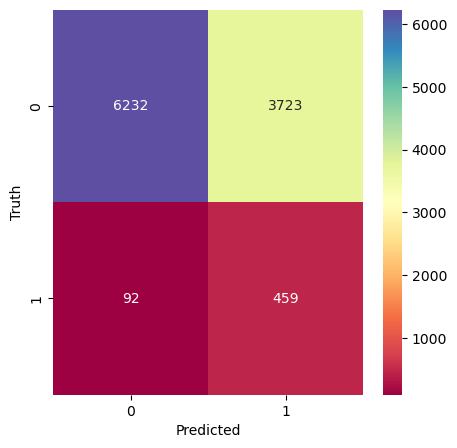

In [87]:
# Create a confusion matrix
cm = confusion_matrix(y_train, y_pred_lg)

# Create a heatmap
plt.figure(figsize=(5,5))
sb.heatmap(cm, annot=True, fmt='d', cmap='Spectral')  
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

The color bar on the right indicates the scale of values, with dark purple representing low values and yellow representing high values. This matrix helps in understanding the model’s performance, particularly its errors. For example, this model has a relatively high number of false positives (3723), as indicated by the lighter color in the top right square. This could be an area to focus on for model improvement.

This is used to get the probabilities of the predictions made by the trained model on the training data X_train.It returns the probabilities of the target class in the model. For each input instance, predict_proba returns a probability estimate that the instance belongs to each of the classes.This can be particularly useful when we want to further analyze the errors made by the model.

In [88]:
y_pred_prob_lg= grid_search.predict_proba(X_train)
y_pred_prob_lg

array([[9.99908892e-01, 9.11082088e-05],
       [9.99955683e-01, 4.43168743e-05],
       [9.99963211e-01, 3.67892623e-05],
       ...,
       [7.82904922e-01, 2.17095078e-01],
       [6.71573499e-01, 3.28426501e-01],
       [7.94393304e-01, 2.05606696e-01]])

In [89]:
y_pred_prob_lg.shape

(10506, 2)

In [90]:
index = [idx for idx, x in enumerate(y_pred_lg) if x==1]
index

[693,
 695,
 697,
 714,
 716,
 717,
 719,
 723,
 726,
 731,
 739,
 745,
 753,
 757,
 765,
 767,
 772,
 776,
 777,
 778,
 780,
 781,
 782,
 783,
 784,
 786,
 789,
 790,
 795,
 796,
 799,
 800,
 804,
 805,
 806,
 807,
 808,
 810,
 811,
 812,
 813,
 814,
 815,
 816,
 817,
 821,
 822,
 823,
 824,
 825,
 826,
 827,
 828,
 833,
 834,
 835,
 837,
 838,
 839,
 841,
 842,
 848,
 849,
 851,
 852,
 856,
 857,
 858,
 859,
 860,
 861,
 862,
 863,
 865,
 866,
 867,
 868,
 870,
 871,
 872,
 873,
 875,
 876,
 877,
 878,
 879,
 881,
 882,
 883,
 885,
 886,
 889,
 890,
 891,
 892,
 893,
 894,
 895,
 896,
 898,
 899,
 906,
 907,
 908,
 915,
 916,
 917,
 919,
 920,
 921,
 923,
 924,
 925,
 926,
 927,
 928,
 939,
 942,
 943,
 944,
 947,
 948,
 949,
 951,
 952,
 953,
 954,
 955,
 956,
 957,
 958,
 960,
 961,
 963,
 964,
 965,
 966,
 968,
 969,
 970,
 971,
 972,
 973,
 974,
 975,
 978,
 979,
 980,
 981,
 982,
 983,
 986,
 987,
 988,
 989,
 992,
 993,
 994,
 995,
 996,
 997,
 998,
 999,
 1000,
 1001,
 1002,
 

In [91]:
y_pred_prob_lg[index,1]

array([0.53094336, 0.57646672, 0.55440954, ..., 0.51198562, 0.52764389,
       0.54798572])

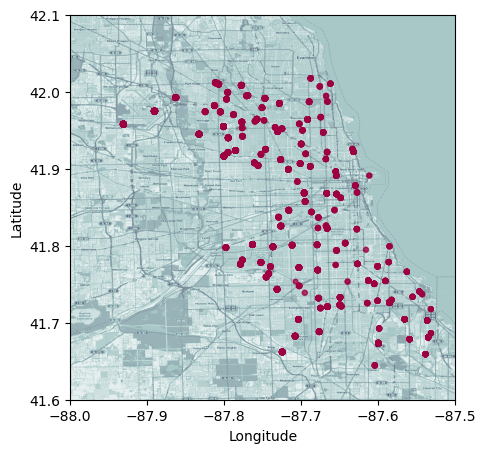

In [92]:
# Load map data
mapdata = np.loadtxt('../data/mapdata_copyright_openstreetmap_contributors.txt')

# Set bounds - (left, right, bottom, top)
mapregion = (-88, -87.5, 41.6, 42.1)

# Map aspect
aspect = mapdata.shape[0] / mapdata.shape[1]

# Assuming that X has two columns representing the geographical coordinates (latitude and longitude)
lat = train['Latitude'][index]
lon = train['Longitude'][index]

# Create a new figure
plt.figure(figsize=(8,5))

# Display the image
plt.imshow(mapdata, cmap=plt.get_cmap('bone'), extent=mapregion)


# Overlay the predictions
plt.scatter(lon, lat, c=y_pred_lg[index], s=(y_pred_prob_lg[index,1]*20), cmap='Spectral', alpha=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

This code is performing a **Grid Search** to find the best hyperparameters for a **Random Forest Classifier**. The hyperparameters being tuned are `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, and `bootstrap`. 

After fitting the model to the training data (`X_train`, `y_train`), it makes predictions on the same training data. Then, it calculates several performance metrics:

- **Precision**: High precision relates to the low false positive rate. The precision in this case is approximately 0.90, which means that when the model predicts a positive class, it's correct about 83% of the time.

- **Recall (Sensitivity)**: The recall in this case is approximately 0.089, which means that the model identifies 8.9% of all actual positive instances.

- **F-score**: This is the weighted average of Precision and Recall. It tries to find the balance between precision and recall. The F-score in this case is approximately 0.16, which is quite low, indicating that the model's precision and recall are not well balanced.

- **Accuracy**: This is the most intuitive performance measure.The accuracy in this case is approximately 0.95, which means that the model correctly predicts the class of an observation about 95% of the time.

- **ROC AUC**: The ROC AUC in this case is approximately 0.54, which is slightly better than random guessing (0.5).

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [30, 60, 90],
    'min_samples_split': [3, 6, 9],
    'min_samples_leaf': [2, 4, 6],
    'bootstrap': [True]
}

# Create a base model
rf = RandomForestClassifier(random_state=45)

# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='precision', n_jobs=-1)

# Fit the grid search to the data
grid_search_rf.fit(X_train, y_train)

# Predict on the train data
y_pred_rf      = grid_search_rf.predict(X_train)
y_pred_prob_rf = grid_search_rf.predict_proba(X_train)

# Calculate metrics
precision = precision_score(y_train, y_pred_rf)
recall = recall_score(y_train, y_pred_rf)
fscore = f1_score(y_train, y_pred_rf)
accuracy = accuracy_score(y_train, y_pred_rf)
roc_auc = roc_auc_score(y_train, y_pred_rf)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F-score: {fscore}')
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')
print(f'Best parameters: {grid_search_rf.best_params_}')

/home/swetha/miniconda3/envs/pylearn/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/swetha/miniconda3/envs/pylearn/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/swetha/miniconda3/envs/pylearn/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

Precision: 0.9081632653061225
Recall: 0.16152450090744103
F-score: 0.27426810477657937
Accuracy: 0.9551684751570532
ROC AUC: 0.5803102163000289
Best parameters: {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 300}


This model has high accuracy, its recall and F-score are quite low, indicating it may not be performing well on the positive class. In this model precision is relatively high, which means when it predicts a positive class, it's often correct. The ROC AUC score suggests the model's performance is slightly better than random guessing. It might be beneficial to further tune the model or try different models to improve recall and F-score.

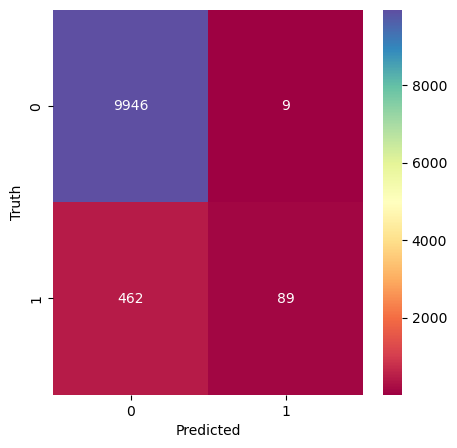

In [94]:
# Create a confusion matrix
cm = confusion_matrix(y_train, y_pred_rf)

# Create a heatmap
plt.figure(figsize=(5,5))
sb.heatmap(cm, annot=True, fmt='d', cmap='Spectral')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


 In this case, it seems the model has a high number of true negatives but struggles with false negatives, indicating it might be predicting the negative class more often. This could be a sign of class imbalance or other issues with the model’s performance.

 This is predicting the class probabilities for the training data using a trained and optimized model, and storing those predictions in y_pred_prob_rf.This can be useful when you want to evaluate the model using metrics such as ROC AUC.

In [95]:
y_pred_prob_rf= grid_search_rf.predict_proba(X_train)
y_pred_prob_rf

array([[9.75768821e-01, 2.42311793e-02],
       [9.95980886e-01, 4.01911435e-03],
       [9.99982639e-01, 1.73611111e-05],
       ...,
       [9.99871103e-01, 1.28896944e-04],
       [9.63983076e-01, 3.60169237e-02],
       [9.93701429e-01, 6.29857071e-03]])

In [96]:
indexx= [idx for idx, x in enumerate(y_pred_rf) if x==1]
indexx

[1503,
 1519,
 1575,
 1576,
 1818,
 1819,
 1821,
 1832,
 1835,
 1836,
 1837,
 1838,
 1839,
 1901,
 1902,
 1935,
 1965,
 1975,
 2195,
 2219,
 2228,
 2272,
 2273,
 2296,
 2362,
 2387,
 2388,
 2407,
 2488,
 2540,
 2541,
 2607,
 2633,
 2855,
 7325,
 7326,
 9372,
 9373,
 9374,
 9376,
 9377,
 9392,
 9409,
 9450,
 9479,
 9523,
 9535,
 9537,
 9613,
 9614,
 9624,
 9630,
 9680,
 9710,
 9731,
 9732,
 9735,
 9758,
 9799,
 9824,
 9853,
 9970,
 9971,
 9983,
 9984,
 9985,
 9986,
 9987,
 9988,
 9989,
 9990,
 9991,
 9992,
 10011,
 10012,
 10013,
 10014,
 10031,
 10032,
 10059,
 10117,
 10118,
 10119,
 10120,
 10121,
 10122,
 10123,
 10124,
 10138,
 10157,
 10158,
 10239,
 10240,
 10241,
 10242,
 10386,
 10387,
 10388]

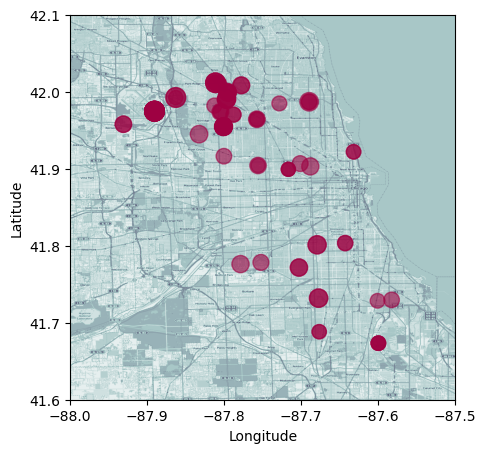

In [97]:
# Load map data
mapdata = np.loadtxt('../data/mapdata_copyright_openstreetmap_contributors.txt')

# Set bounds - (left, right, bottom, top)
mapregion = (-88, -87.5, 41.6, 42.1)

# Map aspect
aspect = mapdata.shape[0] / mapdata.shape[1]

# Assuming that X has two columns representing the geographical coordinates (latitude and longitude)
lat = train['Latitude'][indexx]
lon = train['Longitude'][indexx]

# Create a new figure
plt.figure(figsize=(8,5))

# Display the image
plt.imshow(mapdata, cmap=plt.get_cmap('bone'), extent=mapregion)


# Overlay the predictions
plt.scatter(lon, lat, c=y_pred_rf[indexx], s=(y_pred_prob_rf[indexx,1]*20)**2, cmap='Spectral', alpha=0.6)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [98]:
y_predict_pred_rf = grid_search_rf.predict(X_predict)
y_predict_pred_rf

array([0, 0, 0, ..., 0, 0, 0])

In [99]:
y_predict_pred_prob_rf = grid_search_rf.predict_proba(X_predict)
y_predict_pred_prob_rf

array([[9.96306638e-01, 3.69336219e-03],
       [9.99847092e-01, 1.52908341e-04],
       [9.99166667e-01, 8.33333333e-04],
       ...,
       [9.97989932e-01, 2.01006763e-03],
       [9.97323266e-01, 2.67673430e-03],
       [9.97323266e-01, 2.67673430e-03]])

In [100]:
y_predict_pred_prob_rf[0,1]

0.003693362193362194

In [101]:
index2 = [idx for idx, x in enumerate(y_predict_pred_rf) if x==1]
index2

[17949,
 18376,
 19566,
 19821,
 19823,
 24580,
 26406,
 29007,
 29008,
 29009,
 29010,
 51421,
 52597,
 52851,
 52853,
 53805,
 54059,
 54061,
 54740,
 59332,
 79547,
 79662,
 79710,
 79918,
 81723,
 81724,
 81725,
 82104,
 82106,
 82138,
 82155,
 82157,
 82365,
 82367,
 83031,
 83321,
 83369,
 83575,
 83577,
 84436,
 84510,
 84798,
 84918,
 85718,
 86006,
 86126,
 86885,
 87013,
 87029,
 87798,
 87806,
 88004,
 88006,
 90065,
 92679,
 92680,
 92681,
 92682,
 105331,
 105384,
 105603,
 106577,
 106579,
 106633,
 106841,
 106843,
 107709,
 107710,
 107831,
 107880,
 108090,
 108092,
 108209,
 108461,
 108782,
 109909,
 109920,
 109921,
 109922,
 109923,
 109924,
 109925,
 109926,
 110126,
 110382,
 111249,
 112194]

In [102]:
np.unique(y_predict_pred_rf)

array([0, 1])

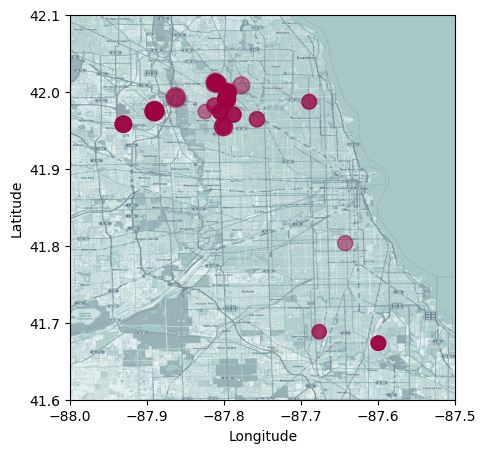

In [103]:
# X_predict has two columns representing the geographical coordinates (latitude and longitude)
lat_predict = predict['Latitude'][index2]
lon_predict = predict['Longitude'][index2]

# Create a new figure
plt.figure(figsize=(8,5))

# Display the image
plt.imshow(mapdata, cmap=plt.get_cmap('bone'), extent=mapregion)

# Overlay the predictions
plt.scatter(lon_predict, lat_predict,c=y_predict_pred_rf[index2], s=(y_predict_pred_prob_rf[index2,1]*20)**2, cmap='Spectral', alpha=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()


The above image tells us  each point could represent the virus presence at the given coordinates. The color and size could indicate the presence of virus in this prediction.

In [104]:
predict['year'] = predict['Date'].apply(lambda x: x.year)


In [105]:
predict[predict['year'] == 2008].head(5)

index  Id       Date                                            Address  \
0      0   1 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1      1   2 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2      2   3 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
3      3   4 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
4      4   5 2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   

               Species  Block           Street  Trap  \
0  [PIPIENS, RESTUANS]     41   N OAK PARK AVE  T002   
1           [RESTUANS]     41   N OAK PARK AVE  T002   
2            [PIPIENS]     41   N OAK PARK AVE  T002   
3         [SALINARIUS]     41   N OAK PARK AVE  T002   
4          [TERRITANS]     41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  ...  cos_jday  ERRATICUS  \
0  4100  N OAK PARK AVE, Chicago, IL  41.95469  ... -0.941634          0   
1  4100  N OAK PARK AVE, Chicago, IL  41.95469  ... -0.941634          0   
2  4100  N OAK PARK AVE, Chicago, IL  41.95469  ... -0.941634          0   
3  4100  N OAK PARK AVE, Chicago, IL  41.95469  ... -0.941634          0   
4  4100  N OAK PARK AVE, Chicago, IL  41.95469  ... -0.941634          0   

   PIPIENS  RESTUANS  SALINARIUS  TARSALIS  TERRITANS  UNSPECIFIED  \
0        1         1           0         0          0            0   
1        0         1           0         0          0            0   
2        1         0           0         0          0            0   
3        0         0           1         0          0            0   
4        0         0           0         0          1            0   

   closest_station  year  
0                1  2008  
1                1  2008  
2                1  2008  
3                1  2008  
4                1  2008  

[5 rows x 23 columns]

In [106]:
years = predict['year'].unique()

The code represents a series of maps that show the locations of weather stations and traps for each year in the years list, and overlays the predictions for certain events. The maps can be useful for visualizing the geographical distribution of the traps and their proximity to the weather stations, as well as the predictions for each location.

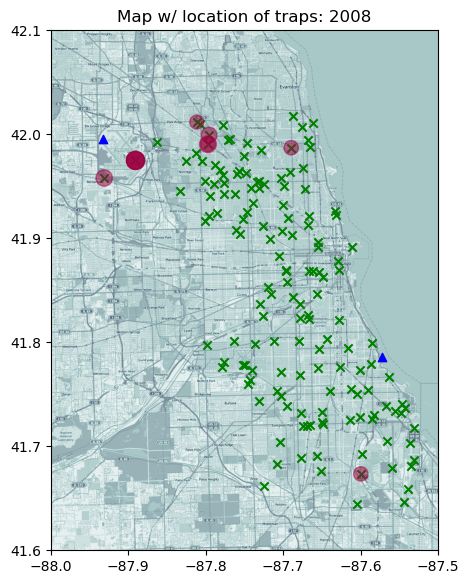

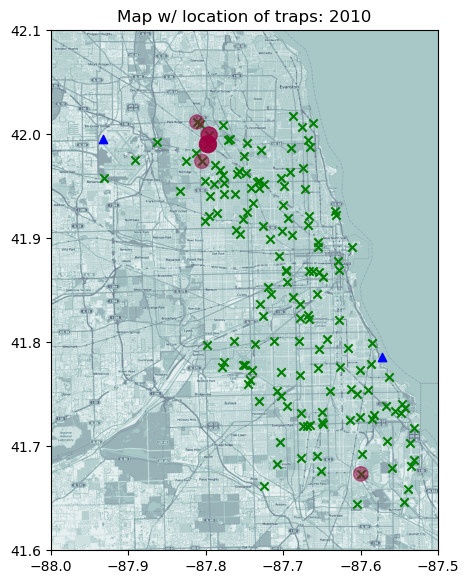

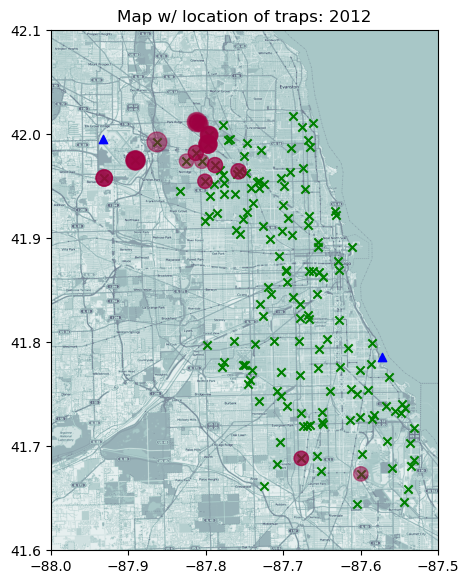

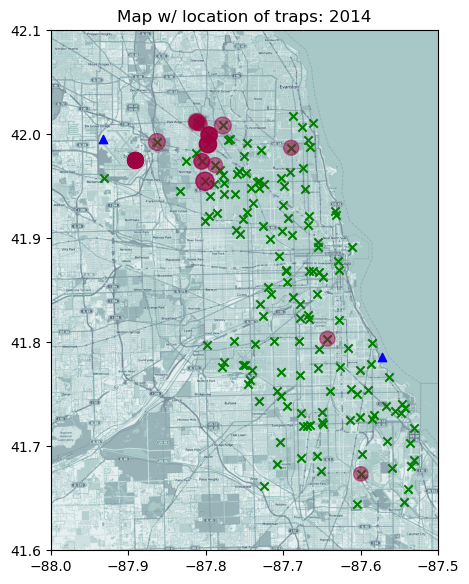

In [107]:
for year in years:

    # Plot map w/ trap locations and station location
    plt.figure(figsize=(5,9))

    # Change the color map to 'hot' for the mapdata
    plt.imshow(mapdata, cmap=plt.get_cmap('bone'), extent=mapregion, aspect=aspect)
    plt.title(f'Map w/ location of traps: {year}')

    # Plot weather stations with a custom color, e.g., 'blue'
    plt.scatter([-87.933, -87.572], [41.995, 41.786], marker='^', color='Blue')

    # Trap locations with a custom color, e.g., 'green'
    trapcoords = predict.loc[predict['year']==year, ['Longitude', 'Latitude']].drop_duplicates()
    plt.scatter(trapcoords['Longitude'], trapcoords['Latitude'], marker='x', color='green')

    # Overlay the predictions
    indexx3    = (predict['year']==year) & (y_predict_pred_rf==1)
    trapcoords = predict.loc[indexx3, ['Longitude', 'Latitude']]
    plt.scatter(trapcoords['Longitude'], trapcoords['Latitude'], c=y_predict_pred_rf[indexx3], s=(y_predict_pred_prob_rf[indexx3, 1]*20)**2, cmap='Spectral', alpha=0.5)

## Spray Data

The City of Chicago also does spraying to kill mosquitos. Spraying can reduce the number of
mosquitos in the area, and therefore might eliminate the appearance of West Nile virus. The
spray GIS data from 2011 and 2013 is included. The training dataset has observations from 2007,
2009, 2011 and 2013. While the prediction dataset requires predictions of presence of WNV for
2008, 2010, 2012, and 2014. The spraying data is insufficient for modeling. For example, in 2011
spraying location map shows that some regions where spraying operations were conducted is out of
the region for which data is available. In 2013, the spraying location data is within the region of the
model. However, the spraying operation might have been performed because of reported cases to
civic authorities or due to multitude of other reasons. In effect, the spraying operation is probably
a result of the outbreak. The only variable that could likely impact training data from 2013 is
if the spraying operation was conducted pre-emptively, in which case the weather conditions that
generally contribute to the presence of mosquitos or outbreak of WNV will be skewed in the training
data. Indeed, it can be inferred from the timeline of the scatter plot below that in many instances
the spraying is a result of the outbreak or when the outbreak has occured. This implies that the
possibility of spraying skewing the observations in the current dataset is unlikely. Furthermore,
to fully account for the influence of spraying on the prediction capabilities of the model, it is
important to take the half-life period of the chemical spray. Because chemical with very short
half-life could have an instantaneous effect in killing mosquitos but might not prevent its future
development. Since this model is required to predict the probability of the outbreak given the
weather conditions, it is logical to ignore this dataset in the context of modeling. For the present
model, spraying is an action that results from prediction.

In [68]:
spray = pd.read_csv('spray.csv')

In [69]:
spray.columns

Index(['Date', 'Time', 'Latitude', 'Longitude'], dtype='object')

In [70]:
spray.head()

Date        Time   Latitude  Longitude
0  2011-08-29  6:56:58 PM  42.391623 -88.089163
1  2011-08-29  6:57:08 PM  42.391348 -88.089163
2  2011-08-29  6:57:18 PM  42.391022 -88.089157
3  2011-08-29  6:57:28 PM  42.390637 -88.089158
4  2011-08-29  6:57:38 PM  42.390410 -88.088858

#### Areas where mosquito repellant was sprayed

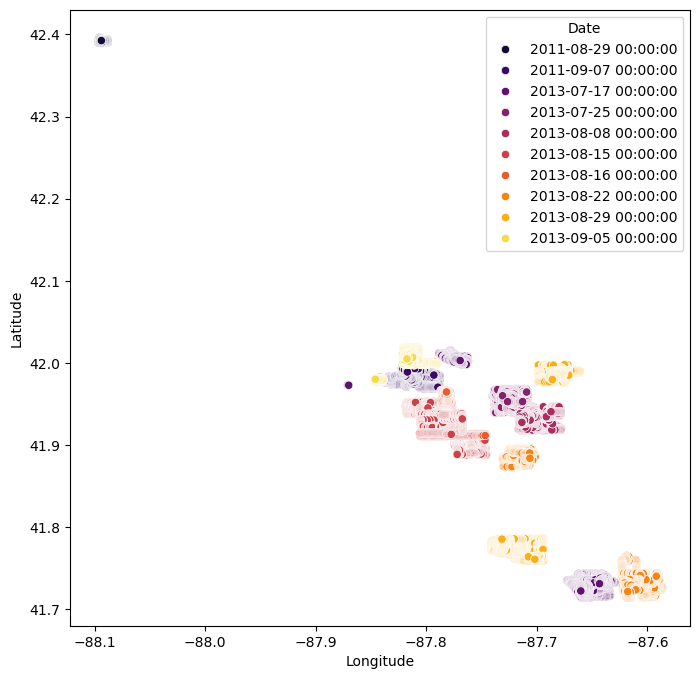

In [71]:
spray['Date'] = pd.to_datetime(spray['Date'])
plt.figure(figsize=(8,8))
sb.scatterplot(data=spray, x='Longitude', y='Latitude', hue='Date',palette='inferno')
plt.show()

Each data point is color-coded according to the date it represents, ranging from “2011-08-29” to “2013-09-05”. The data points are primarily scattered between latitudes 41.9 and 42.0, and longitudes -87.9 and -87.7. There’s an data point at around latitude 42.4 and longitude -88, marked in dark purple indicating it’s dated “2011-08-29”. This plot provides a clear visualization of the geographical distribution of data over time.

In [72]:
spray['year'] = spray['Date'].apply(lambda x: x.year)

In [73]:
spray.head()

Date        Time   Latitude  Longitude  year
0 2011-08-29  6:56:58 PM  42.391623 -88.089163  2011
1 2011-08-29  6:57:08 PM  42.391348 -88.089163  2011
2 2011-08-29  6:57:18 PM  42.391022 -88.089157  2011
3 2011-08-29  6:57:28 PM  42.390637 -88.089158  2011
4 2011-08-29  6:57:38 PM  42.390410 -88.088858  2011

In [74]:
spray[spray['year'] == 2013]

Date        Time   Latitude  Longitude  year
2209  2013-07-17  7:45:45 PM  41.997728 -87.767532  2013
2210  2013-07-17  7:45:55 PM  41.997990 -87.768085  2013
2211  2013-07-17  7:46:05 PM  41.998237 -87.768623  2013
2212  2013-07-17  7:46:15 PM  41.998510 -87.769225  2013
2213  2013-07-17  7:46:25 PM  41.998793 -87.769833  2013
...          ...         ...        ...        ...   ...
14830 2013-09-05  8:34:11 PM  42.006587 -87.812355  2013
14831 2013-09-05  8:35:01 PM  42.006192 -87.816015  2013
14832 2013-09-05  8:35:21 PM  42.006022 -87.817392  2013
14833 2013-09-05  8:35:31 PM  42.005453 -87.817423  2013
14834 2013-09-05  8:35:41 PM  42.004805 -87.817460  2013

[12626 rows x 5 columns]

In [75]:
spray['year'].unique()

array([2011, 2013])

In [76]:
years = spray['year'].unique()

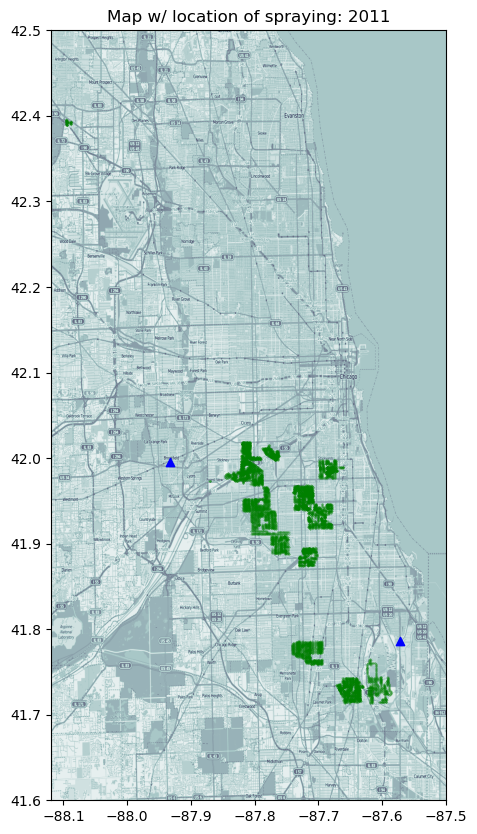

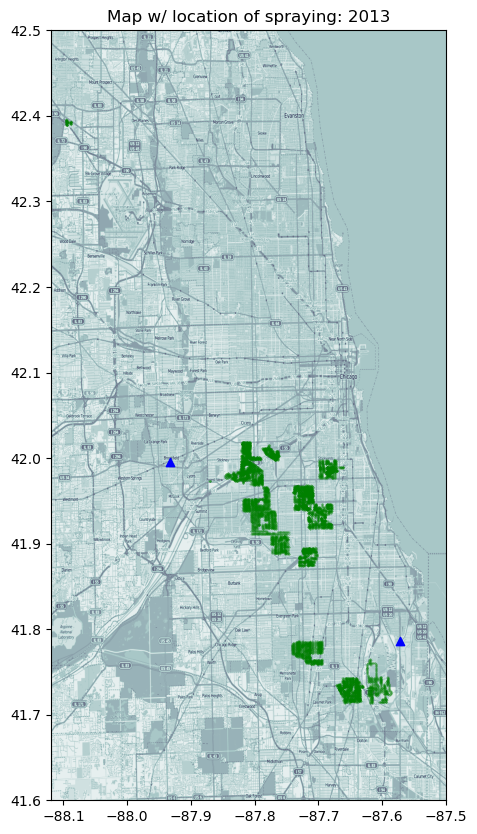

In [77]:
for year in years:

    # Plot map w/ trap locations and station location
    plt.figure(figsize=(10,10))

    # Change the color map to 'hot' for the mapdata
    plt.imshow(mapdata, cmap=plt.get_cmap('bone'), extent=(-88.12, -87.5, 41.6, 42.5), aspect=aspect)
    plt.title(f'Map w/ location of spraying: {year}')

    # Plot weather stations with a custom color, e.g., 'blue'
    plt.scatter([-87.933, -87.572], [41.995, 41.786], marker='^', color='Blue')

    # Trap locations with a custom color,
    plt.scatter(spray['Longitude'], spray['Latitude'], marker='x', s=0.5,color='Green', alpha=0.2)

The code represents a series of maps that show the locations of weather stations and spray operations for each year in the years list. The maps can be useful for visualizing the geographical distribution of the spray operations and their proximity to the weather stations.

### Conclusion

The Logistic Regression model is better at identifying positive cases, but often misclassifies. The Random Forest model is more accurate overall, but misses many positive cases. The choice between the two depends on whether it’s more important to correctly identify positive cases or to be generally accurate.